In [1]:
import scipy as sp
from pylab import *
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pylab as pylabㅌ
import pandas as pd
import seaborn as sns
import random


from InitializeSpeciesPool import *
from LV import *
from VariousMetrics import *

sns.set_style("ticks")

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}



session_name="results/test"


# Function Definition

In [16]:
from scipy.integrate import odeint

'''

def gLV(y, t, I_simul, g_simul, k_simul):
    dydt = np.zeros_like(y)
    for i in range(len(y)):
        dydt[i] = g_simul[i]* y[i] * (1- np.sum(I_simul[i,:] * y)/k_simul[i])
    return dydt

def run_lotka_volterra_dynamics(y0, t, s_idx, I, g, k):
    
    s_idx=np.where(s_idx)[0].tolist()
    N=len(y0)
    y0_simul=y0[s_idx]
    I_simul=I[s_idx,:]
    I_simul=I_simul[:,s_idx]
    g_simul=g[s_idx]
    k_simul=k[s_idx]
    
    
    y = odeint(gLV, y0_simul, t, args=(I_simul, g_simul, k_simul))
    y_out=np.zeros(N)
    for i in range(y.shape[1]):
        y_out[s_idx[i]]=y[-1,i] 
    return y
'''
def gLV_env(y, t, beta, delta, migration_rate, I, g, k, p, q, varIdx):
    # p : species -> pH
    # q : pH -> species
    dydt = np.zeros(len(varIdx['env']) + len(varIdx['species']))
    
    growth_rate_multiplier = 1 - (np.matmul(I, y[varIdx['species']])) / k + np.matmul(q, y[varIdx['env']])
    
    dydt[varIdx['species']] = np.multiply(np.multiply(y[varIdx['species']], g), growth_rate_multiplier) + migration_rate #- death_rate * y[varIdx['species']]
    dydt[varIdx['env']] = delta * (-y[varIdx['env']]) + beta* np.matmul(p, y[varIdx['species']]) - delta * 0.001 * y[varIdx['env']]**3
    
    return dydt

def run_gLV_env_dynamics(y0_species, y0_env, t, system_config, species_index, env_index, to_plot=False):
    

    N=system_config['N']
    N_env=system_config['N_env']
    beta = system_config['beta']
    delta = system_config['delta']
    migration_rate = system_config['migration_rate']
    I = system_config['I']
    g = system_config['g']
    k = system_config['k']
    p = system_config['p']
    q = system_config['q']
                                   
    I=I[species_index,:]
    I=I[:,species_index]
    g=g[species_index]
    k=k[species_index]
    p=p[:,species_index] # p is N_env x N
    p=p[env_index,:]                               
    q=q[species_index,:] # q is N x N_Nev
    q=q[:,env_index]                             
    
    varIdx={'species' : np.arange(len(species_index)),
           'env' : np.arange(len(species_index),len(species_index)+len(env_index))}
    y0=np.concatenate((y0_species, y0_env))
    
    y = odeint(gLV_env, y0, t, args=(beta, delta, migration_rate, I, g, k, p, q, varIdx))
    y_out={}
    y_out_species=np.zeros(N)
    y_out_env=np.zeros(N_env)

    for i in range(len(species_index)):
        y_out_species[species_index[i]]=y[-1,i]
        y_out['species']=y_out_species
    for i in range(len(env_index)):
        y_out_env[env_index[i]]=y[-1,len(species_index)+i]
        y_out['env']=y_out_env
    
    if to_plot:
        # Create plots
        fig, axs = plt.subplots(2, 1, figsize=(10, 8))  # 2 Rows, 1 Column

        # Plotting species data
        for i in range(len(species_index)):
            axs[0].plot(t, y[:, i], label=f'Species {i+1}')
        axs[0].set_title('Species Time Series')
        axs[0].set_xlabel('Time (log scale)')
        axs[0].set_ylabel('Value (log scale)')
        axs[0].set_xscale('log')
        axs[0].set_yscale('log')
        axs[0].axhline(y=1e-3, color='r', linestyle='dotted', linewidth=1)
        axs[0].legend()

        # Plotting environmental data
        for i in range(len(env_index)):
            axs[1].plot(t, y[:, len(species_index)+i], label=f'Env Variable {i+1}')
        axs[1].set_title('Environmental Variables Time Series')
        axs[1].set_xlabel('Time (log scale)')
        axs[1].set_ylabel('Value (log scale)')
        axs[1].set_xscale('log')
        axs[1].legend()     
        plt.tight_layout()
        plt.show()
    print(y_out)
    return y_out


# PARAMETER DEFINITION

In [3]:
def uniform_distribution(u,o):
    return u+(2*o)*np.random.random()-o

def input_distribution(k):
    return np.random.exponential(k)

In [13]:
session_path='Results/Session_Test'

if not os.path.isdir(session_path):
    os.mkdir(session_path)
# functions for uniform 

f_I = lambda : uniform_distribution(0.6,0.3)
f_g = lambda : np.ones(1)
f_k = lambda : np.ones(1)
f_p = lambda : uniform_distribution(0,1)
f_q = lambda : uniform_distribution(0,1)
f_beta = lambda : np.ones(1)



N=48
N_env=1


I = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        I[i,j] = f_I()
for i in range(N):
    I[i,i] =1

g = np.zeros((N))
for i in range(N):
    g[i] = f_g()

k = np.zeros((N))
for i in range(N):
    k[i] = f_k()   

p = np.zeros((N_env, N))
for i in range(N_env):
    for j in range(N):
        p[i,j] = f_p()

q = np.zeros((N, N_env))
for i in range(N):
    for j in range(N_env):
        q[i,j] = f_q()

beta = np.zeros(N_env)
for i in range(N_env):
    beta[i]=f_beta()

delta = 0.01
migration_rate=1e-5
system_config = {
    'I': I,
    'g': g,
    'k': k,
    'p': p,
    'q': q,
    'beta': beta,
    'delta': delta,
    'migration_rate' : migration_rate,
    'N': N,
    'N_env': N_env,
} 

file_path = f'{session_path}/system_config.json'



In [5]:
#Typical growth rates : 0.3-1.5 per hour
#Dilution 1/100 per 24 hour = 0.1918 per hour


In [14]:
def one_hot_vector(n_species,i):
    # Create an array of length n_species with all values set to 0.001
    vector = np.full(n_species, 0.0001)
    
    # Set the ith element to 0.1
    vector[i] = 0.01
    
    return vector

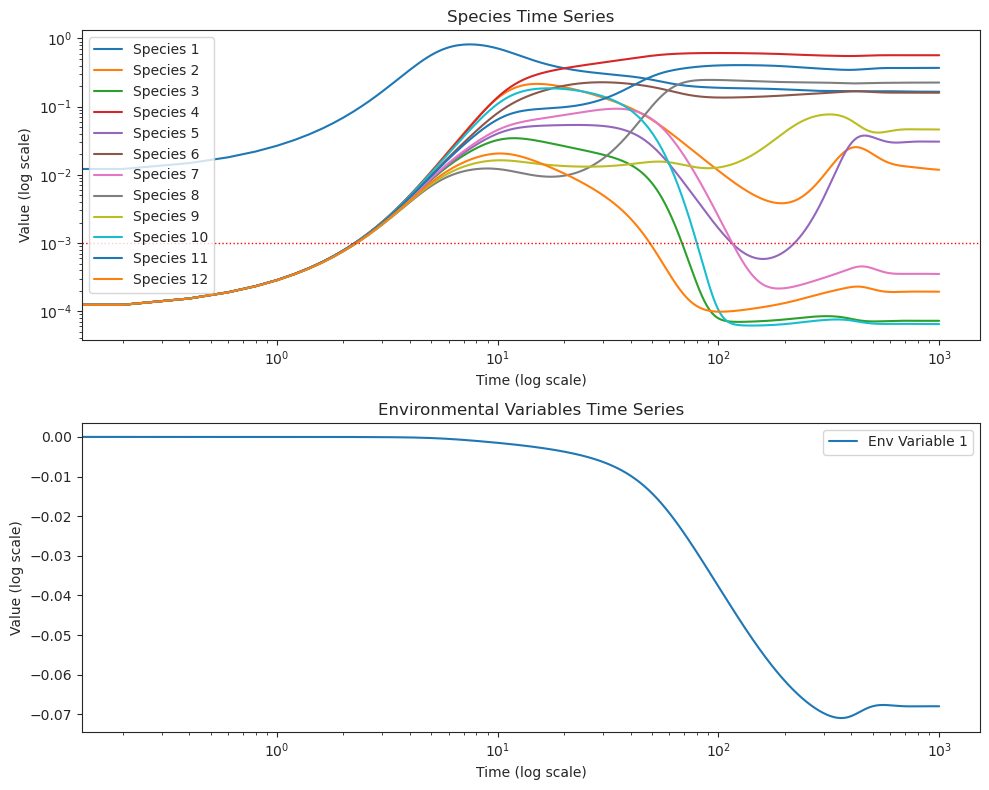

{'species': array([1.65571025e-01, 1.18696702e-02, 7.23572124e-05, 5.67188567e-01,
       3.06962627e-02, 1.60000561e-01, 3.51672404e-04, 2.25632557e-01,
       4.62524969e-02, 6.47694675e-05, 3.70065966e-01, 1.93442091e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), 'env': array([-0.06795621])}


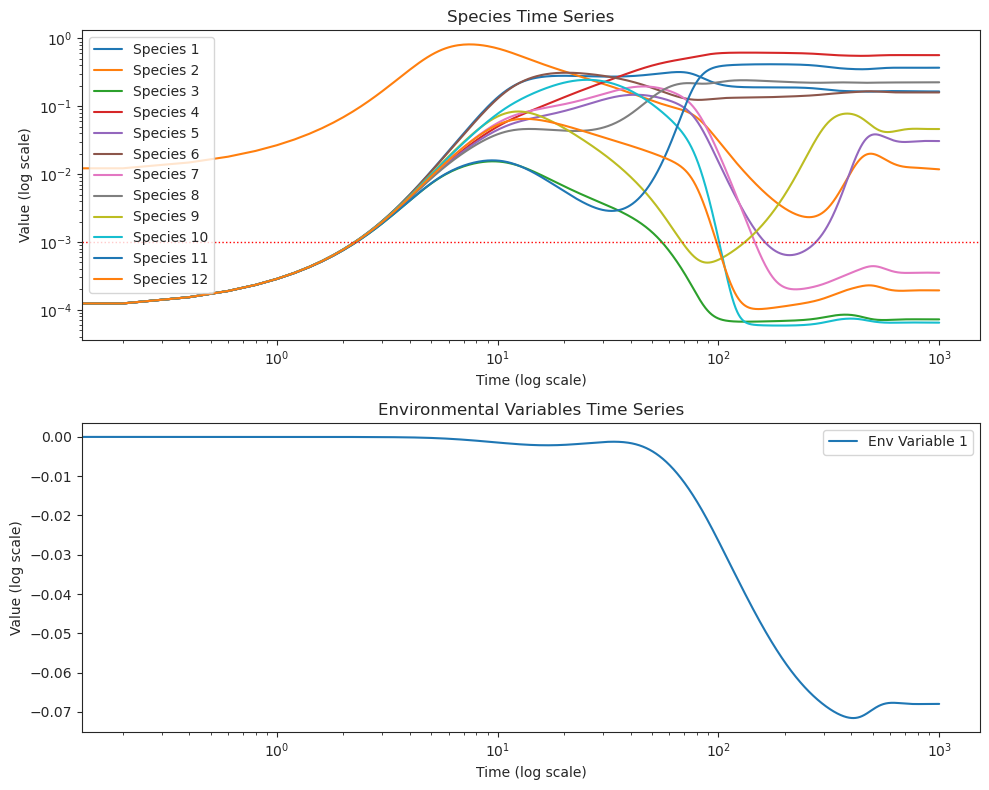

{'species': array([1.65506309e-01, 1.17701441e-02, 7.23460805e-05, 5.67229055e-01,
       3.07220556e-02, 1.59966094e-01, 3.51490366e-04, 2.25687461e-01,
       4.62290815e-02, 6.47333787e-05, 3.70175534e-01, 1.93421822e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), 'env': array([-0.0679555])}


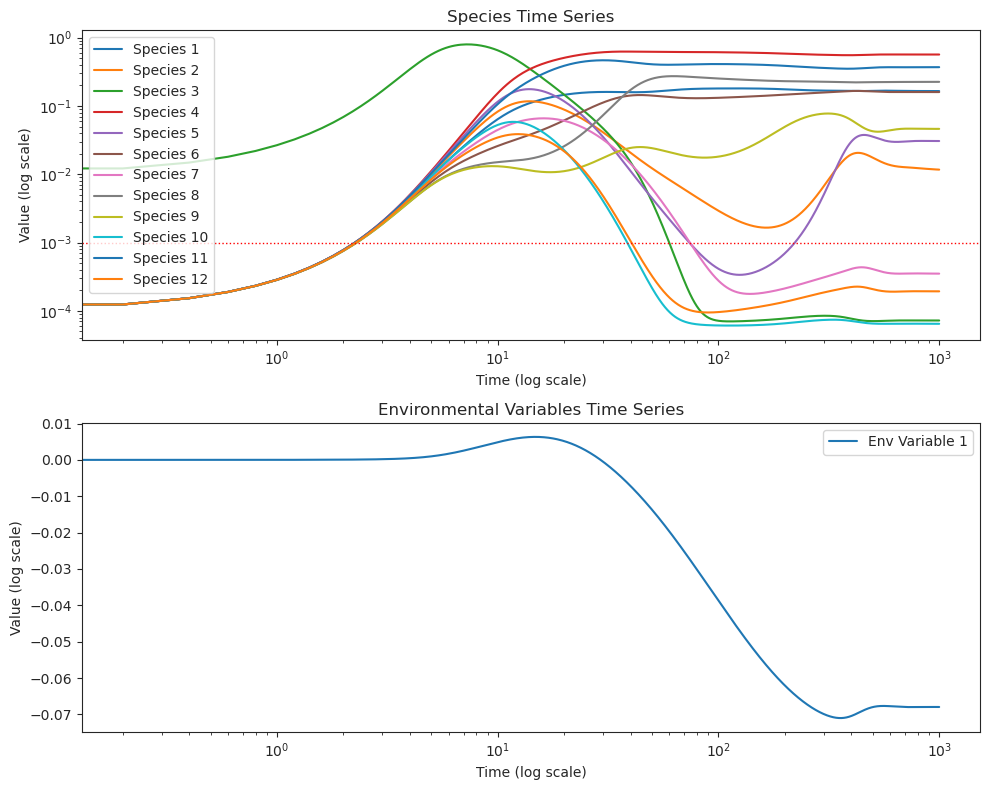

{'species': array([1.65468421e-01, 1.17073212e-02, 7.23593413e-05, 5.67231963e-01,
       3.07057309e-02, 1.59946036e-01, 3.51212969e-04, 2.25716438e-01,
       4.62764918e-02, 6.47270662e-05, 3.70213723e-01, 1.93386327e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), 'env': array([-0.06795991])}


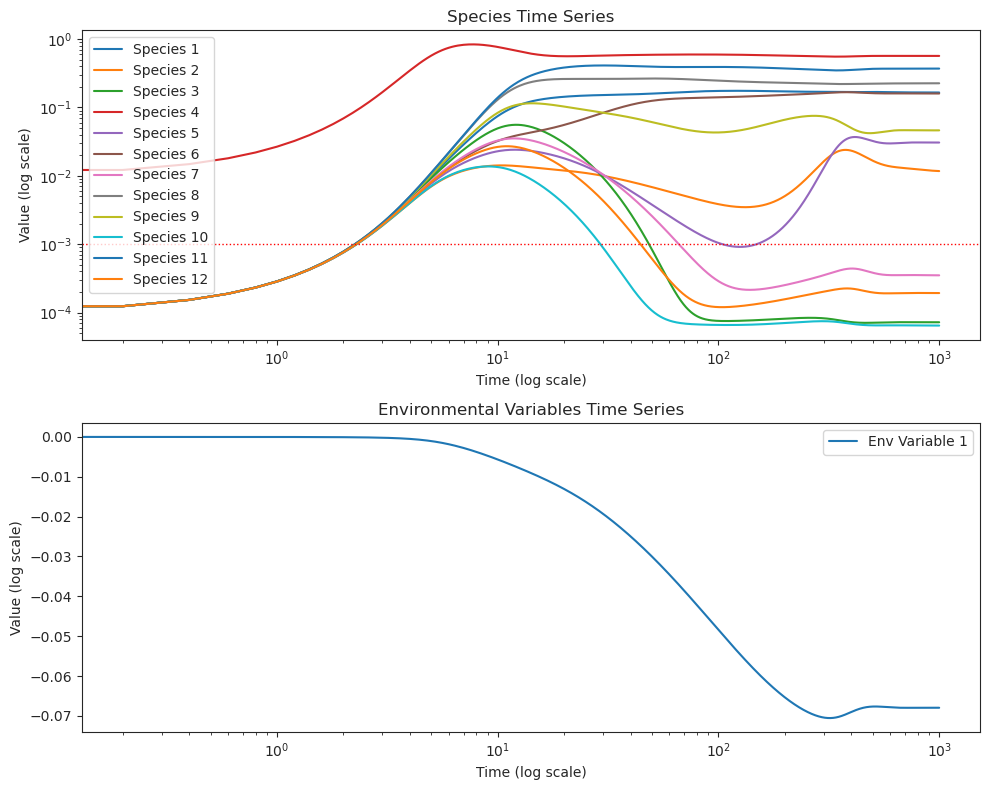

{'species': array([1.65486829e-01, 1.17465617e-02, 7.23622405e-05, 5.67210327e-01,
       3.07067291e-02, 1.59962999e-01, 3.51344113e-04, 2.25697532e-01,
       4.62864172e-02, 6.47405423e-05, 3.70166340e-01, 1.93423345e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), 'env': array([-0.06796082])}


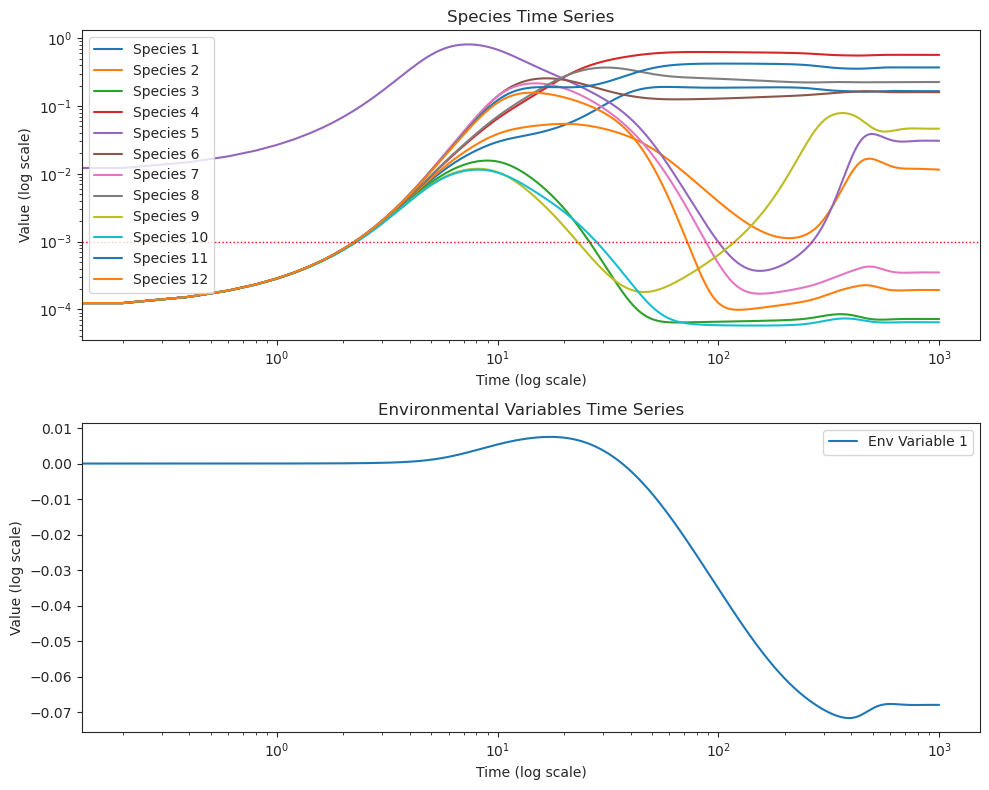

{'species': array([1.65363872e-01, 1.15383900e-02, 7.23535547e-05, 5.67289545e-01,
       3.07243416e-02, 1.59887075e-01, 3.50781115e-04, 2.25804753e-01,
       4.62743520e-02, 6.46763533e-05, 3.70382652e-01, 1.93324635e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), 'env': array([-0.06796139])}


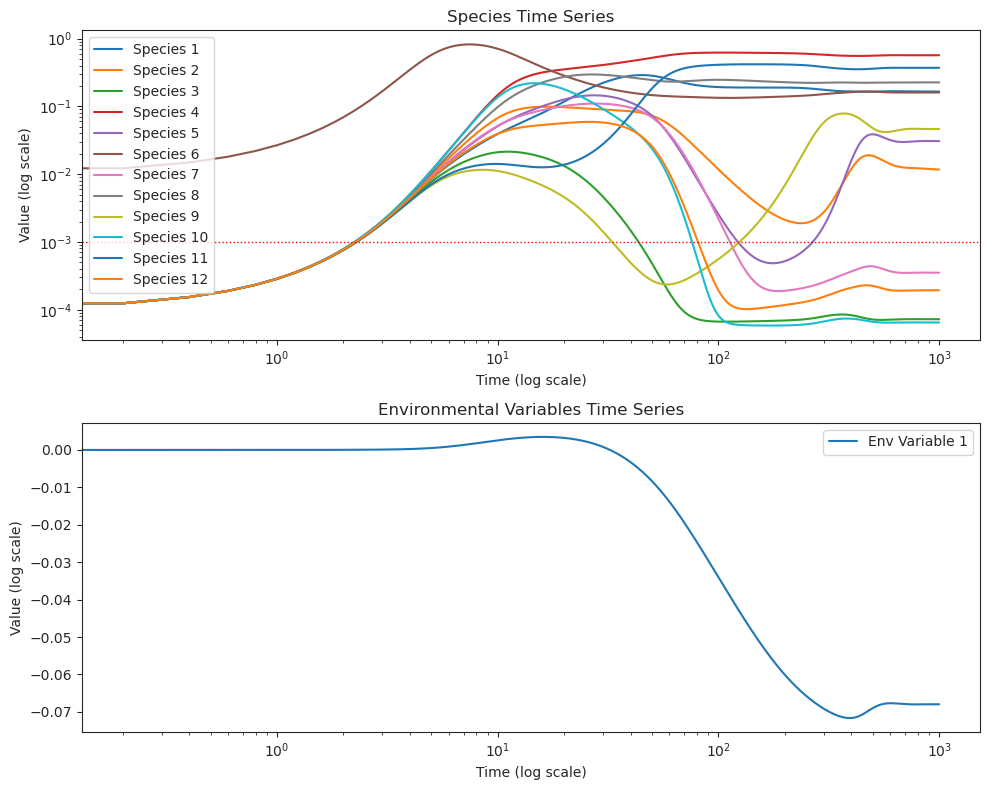

{'species': array([1.65454311e-01, 1.16827773e-02, 7.23507741e-05, 5.67251313e-01,
       3.07180266e-02, 1.59935691e-01, 3.51196512e-04, 2.25730689e-01,
       4.62508099e-02, 6.47132769e-05, 3.70252148e-01, 1.93377182e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), 'env': array([-0.06795796])}


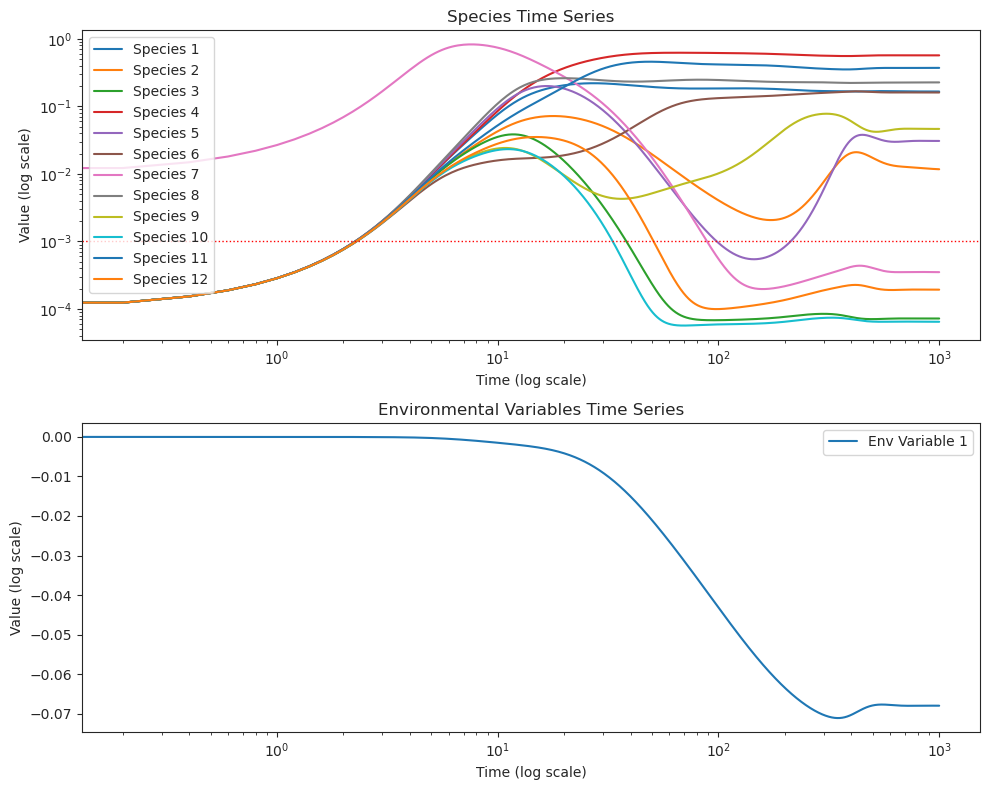

{'species': array([1.65464178e-01, 1.17016884e-02, 7.23604379e-05, 5.67231434e-01,
       3.07054868e-02, 1.59944661e-01, 3.51194786e-04, 2.25719333e-01,
       4.62810948e-02, 6.47264818e-05, 3.70216501e-01, 1.93386591e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), 'env': array([-0.06796041])}


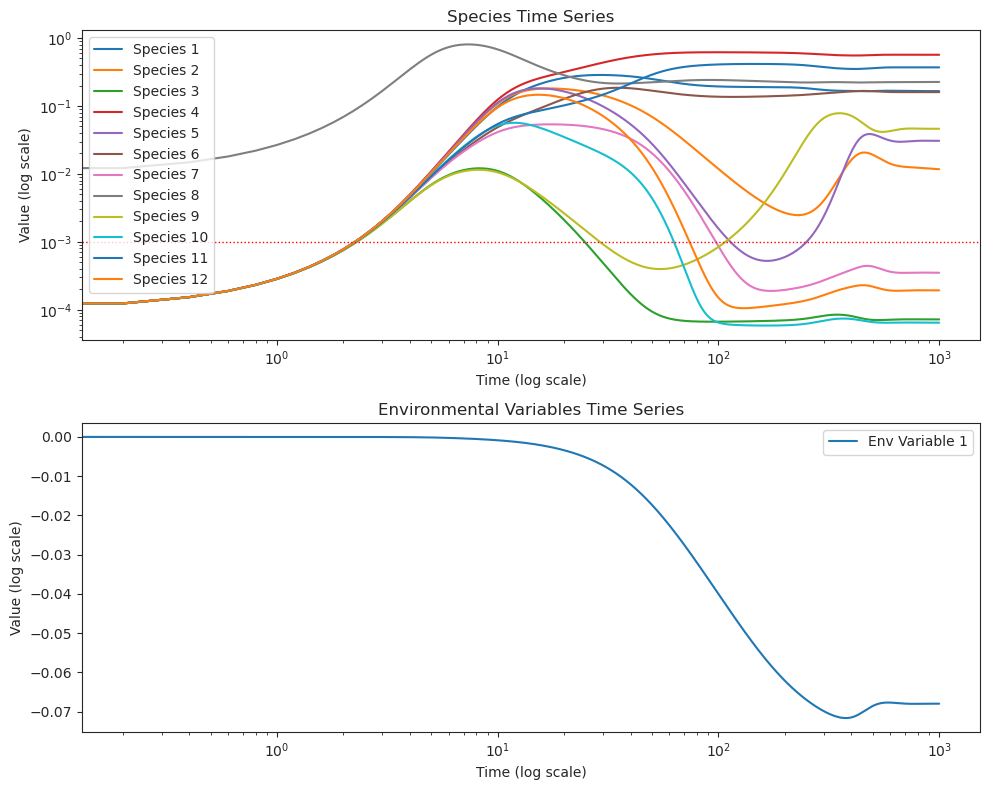

{'species': array([1.65489822e-01, 1.17369313e-02, 7.23539050e-05, 5.67233337e-01,
       3.07077408e-02, 1.59953806e-01, 3.51313087e-04, 2.25701395e-01,
       4.62540259e-02, 6.47304640e-05, 3.70197712e-01, 1.93388476e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), 'env': array([-0.06795754])}


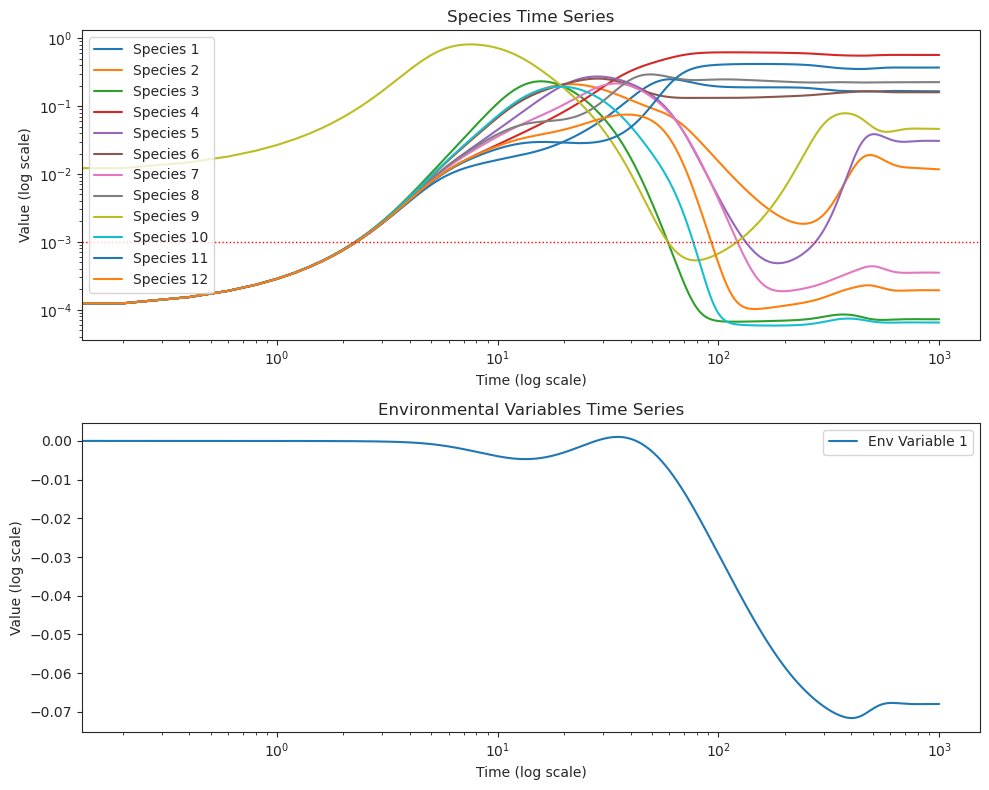

{'species': array([1.65464561e-01, 1.17014465e-02, 7.23486305e-05, 5.67247093e-01,
       3.07216018e-02, 1.59942443e-01, 3.51273161e-04, 2.25722008e-01,
       4.62432008e-02, 6.47166931e-05, 3.70236870e-01, 1.93390744e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), 'env': array([-0.06795726])}


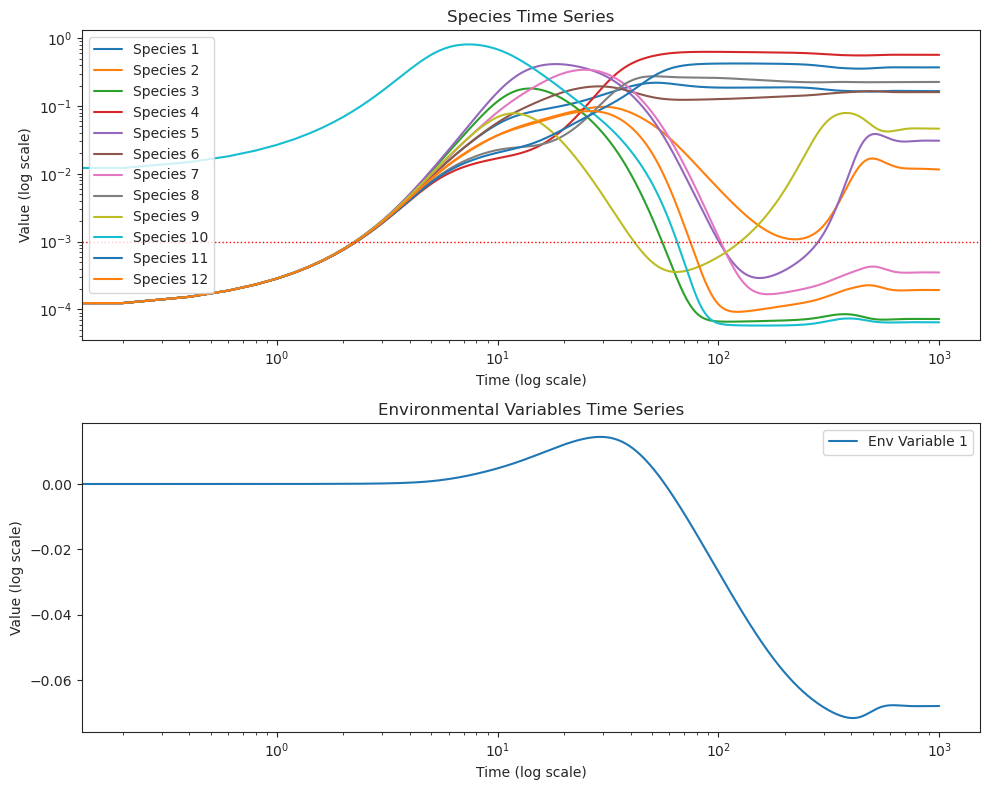

{'species': array([1.65377952e-01, 1.15657545e-02, 7.23492194e-05, 5.67283888e-01,
       3.07324433e-02, 1.59897236e-01, 3.50907431e-04, 2.25792626e-01,
       4.62601276e-02, 6.46804297e-05, 3.70361395e-01, 1.93348762e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), 'env': array([-0.06796019])}


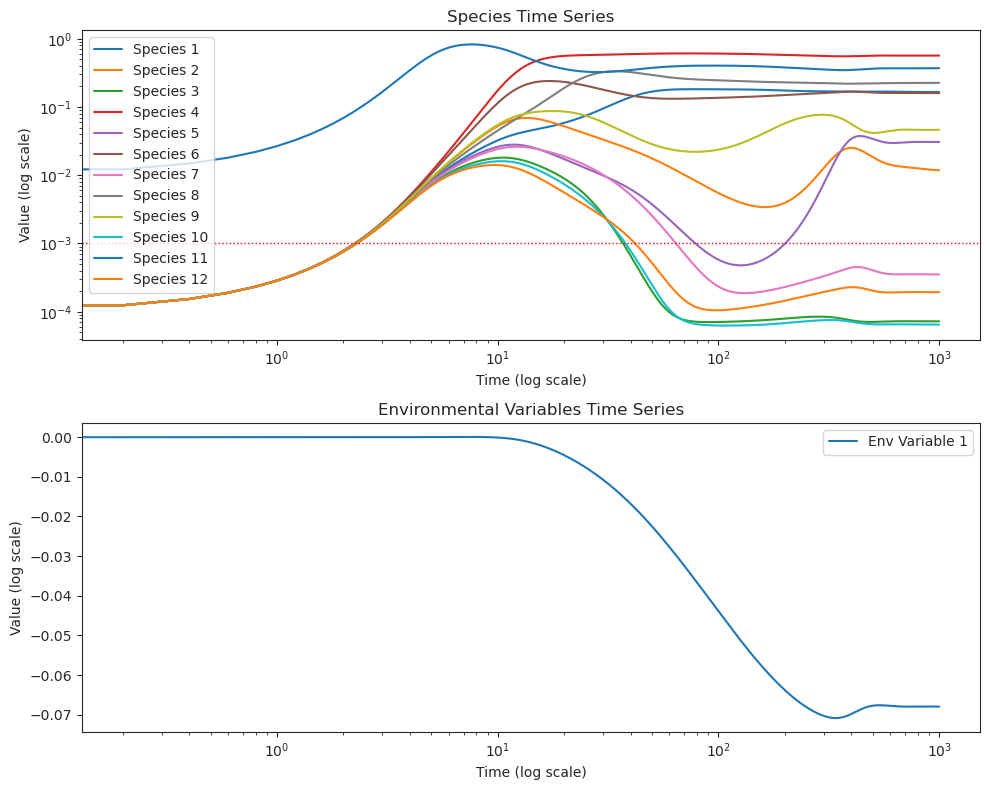

{'species': array([1.65533836e-01, 1.18150474e-02, 7.23602627e-05, 5.67197367e-01,
       3.06995094e-02, 1.59983924e-01, 3.51519334e-04, 2.25661138e-01,
       4.62700211e-02, 6.47572848e-05, 3.70109318e-01, 1.93432591e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), 'env': array([-0.06795845])}


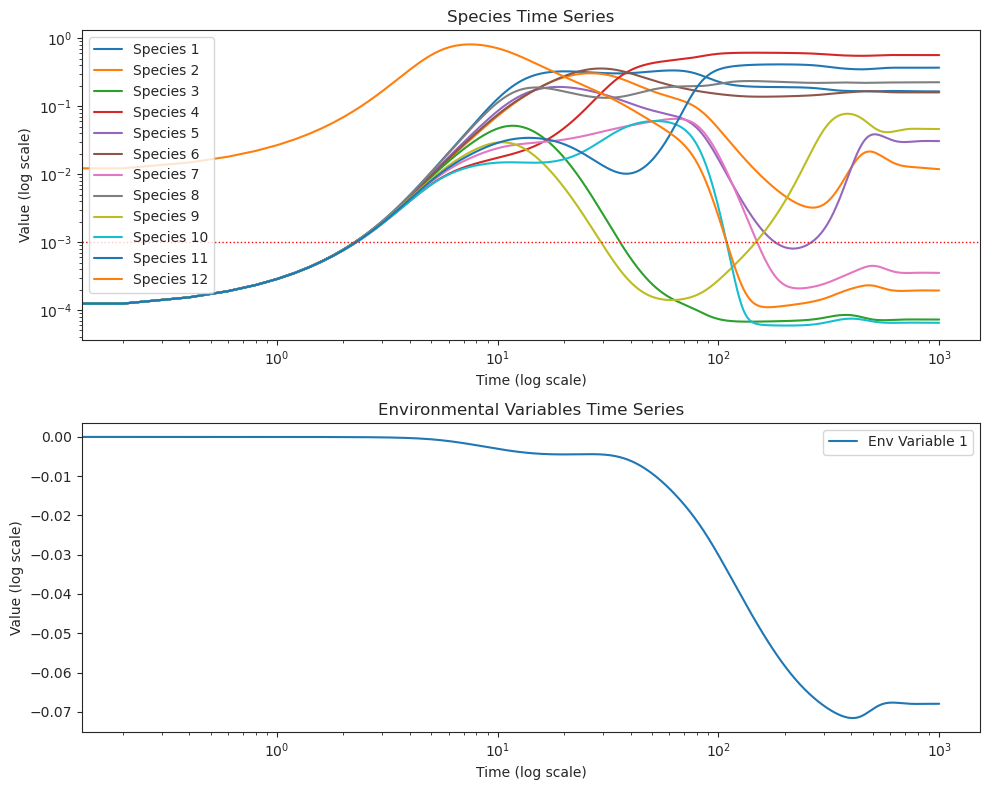

{'species': array([1.65552287e-01, 1.18419380e-02, 7.23454736e-05, 5.67210069e-01,
       3.07166502e-02, 1.59989971e-01, 3.51687630e-04, 2.25650079e-01,
       4.62190706e-02, 6.47523664e-05, 3.70110179e-01, 1.93443997e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), 'env': array([-0.06795386])}


In [25]:
np.random.seed(42)
system_config['beta'] = np.array([0.002])

species_index=np.arange(0,12)
env_index=np.array([0])

for i in range(12):
    y0_species=one_hot_vector(12,i)
    y0_env=[0]
    t=np.linspace(0, 1000, 5000)

    y_out = run_gLV_env_dynamics(y0_species, y0_env, t, system_config, species_index, env_index, to_plot=True)

In [23]:
y_out

{'species': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 9.34552132e-06, 2.15691674e-05,
        0.00000000e+00, 0.00000000e+00, 8.02290679e-06, 0.00000000e+00,
        0.00000000e+00, 2.39379192e-05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 7.13095790e-06, 0.00000000e+00, 9.16679927e-06,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.72768959e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.36176780e-06,
        1.82005716e-05, 0.00000000e+00, 1.09940907e+00, 8.11350451e-06,
        0.00000000e+00, 0.00000000e+00, 2.88587346e-05, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 'env': array([-1.23285238])}

In [28]:
np.linspace(0, 1000, 5000)

array([0.00000000e+00, 2.00040008e-01, 4.00080016e-01, ...,
       9.99599920e+02, 9.99799960e+02, 1.00000000e+03])

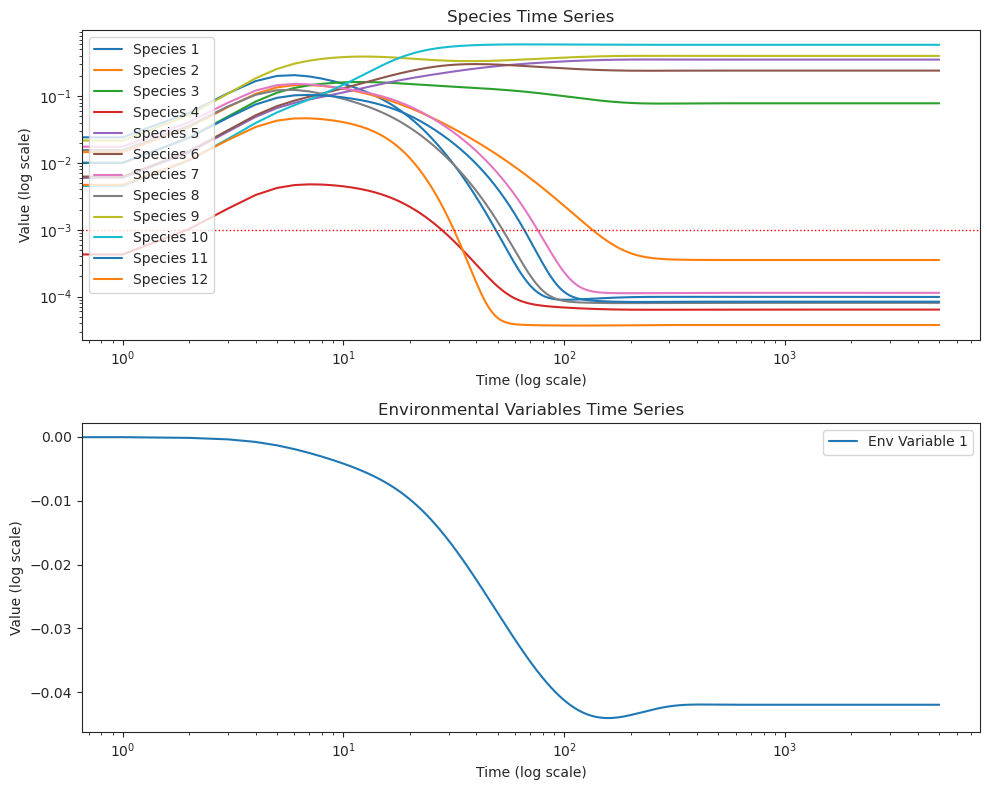

{'species': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.75159183e-05,
       3.98736741e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       8.38077144e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.13679771e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.05729757e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.50797868e-01, 5.84682251e-01, 7.78946038e-02, 9.87037421e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.40308275e-01, 0.00000000e+00, 0.00000000e+00,
       3.52543251e-04, 0.00000000e+00, 0.00000000e+00, 6.38625458e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), 'env': array([-0.04194838])}


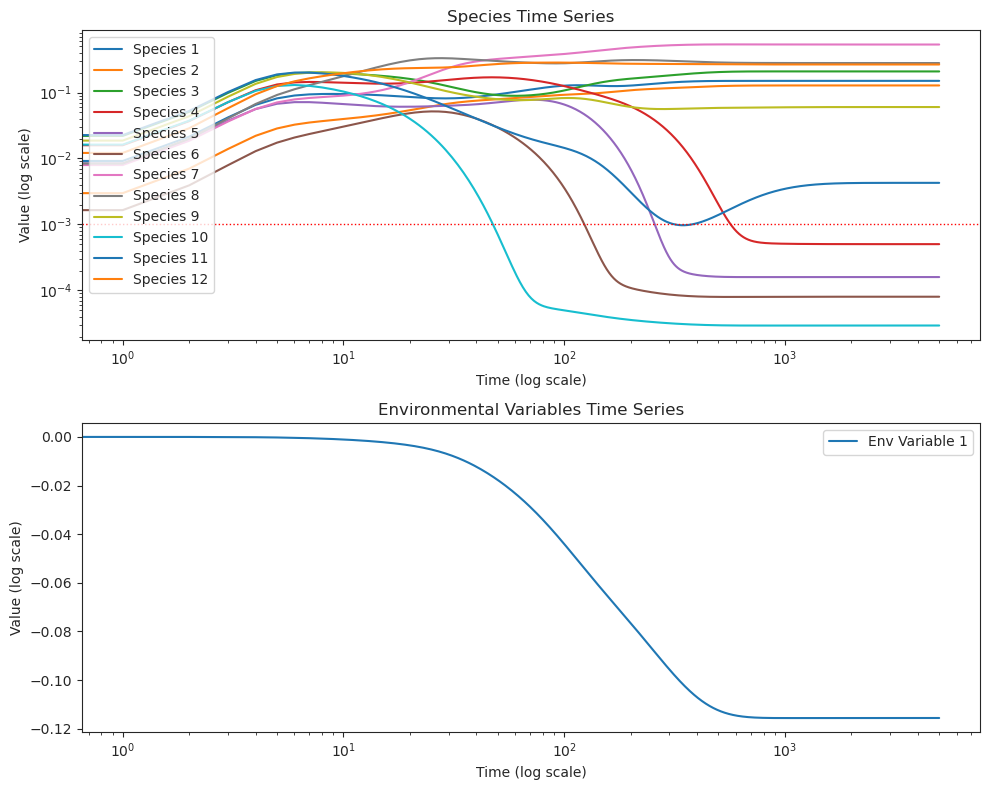

{'species': array([0.00000000e+00, 0.00000000e+00, 2.93867407e-05, 0.00000000e+00,
       2.08626645e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.79610599e-01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       8.02568565e-05, 0.00000000e+00, 4.27162419e-03, 2.65840669e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.59421632e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       6.02047844e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 5.33715548e-01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.50195683e-01,
       0.00000000e+00, 5.02837364e-04, 1.27937135e-01, 0.00000000e+00]), 'env': array([-0.1156187])}


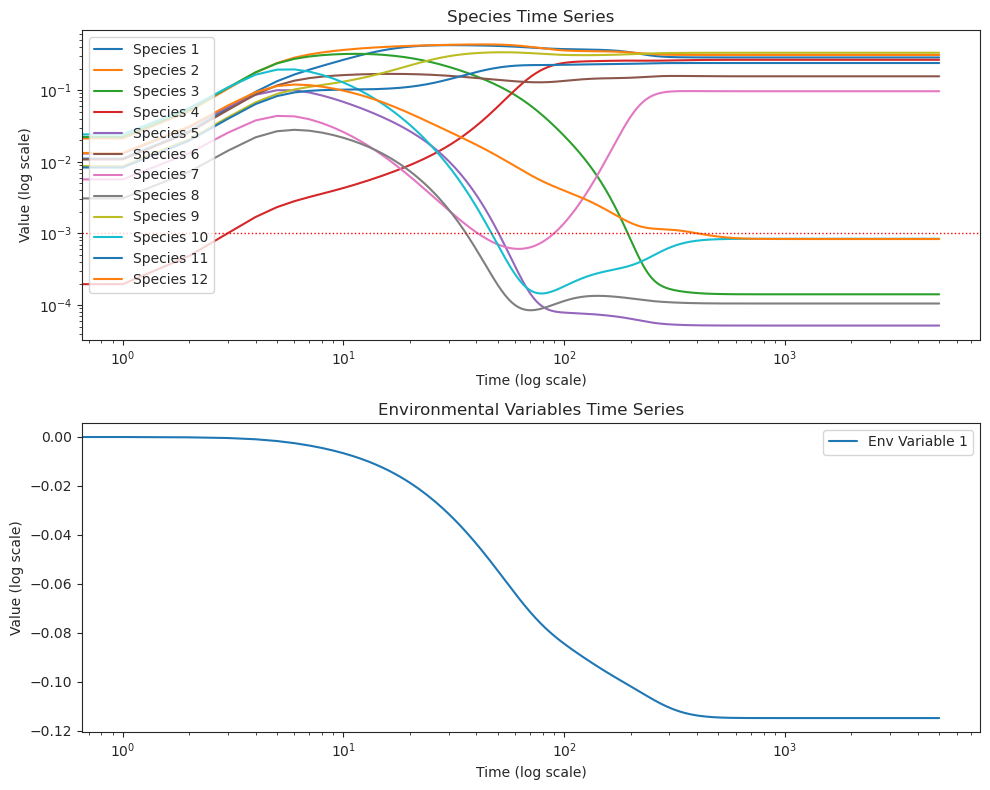

{'species': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 8.36453243e-04, 0.00000000e+00, 1.41604550e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.55931901e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.65108848e-01,
       0.00000000e+00, 2.85769559e-01, 3.32463004e-01, 0.00000000e+00,
       2.38881298e-01, 1.05339913e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 8.43257704e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 5.18622131e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.64891392e-02,
       3.09763221e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), 'env': array([-0.11477835])}


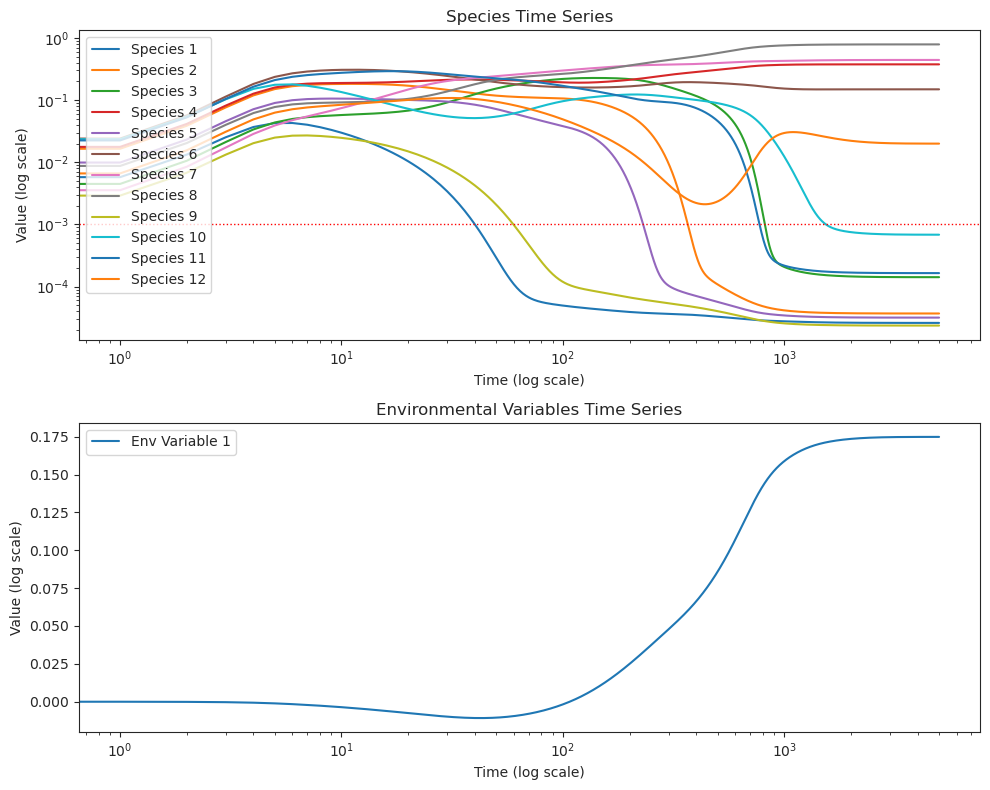

{'species': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.18050536e-05, 1.48954496e-01,
       0.00000000e+00, 4.41800672e-01, 0.00000000e+00, 0.00000000e+00,
       2.61555437e-05, 7.85776181e-01, 0.00000000e+00, 3.70528096e-05,
       0.00000000e+00, 1.65199983e-04, 0.00000000e+00, 1.42135434e-04,
       0.00000000e+00, 1.99474890e-02, 0.00000000e+00, 0.00000000e+00,
       2.36965121e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.75337685e-01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.84803949e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), 'env': array([0.17492881])}


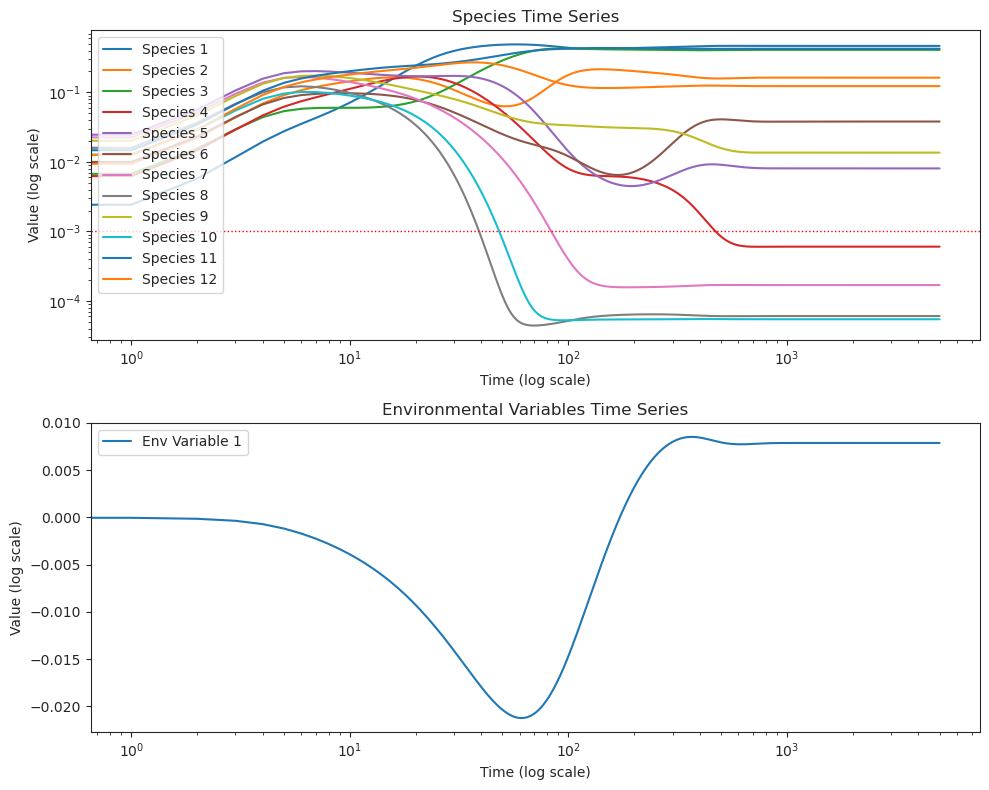

{'species': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 4.66146839e-01, 0.00000000e+00,
       0.00000000e+00, 3.80888087e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 8.05703361e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 6.07256755e-05, 0.00000000e+00, 0.00000000e+00,
       4.08910852e-01, 0.00000000e+00, 1.23064311e-01, 0.00000000e+00,
       1.62804875e-01, 1.35977242e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 6.03934513e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.69408995e-04, 5.45717447e-05,
       4.24509268e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), 'env': array([0.0078795])}


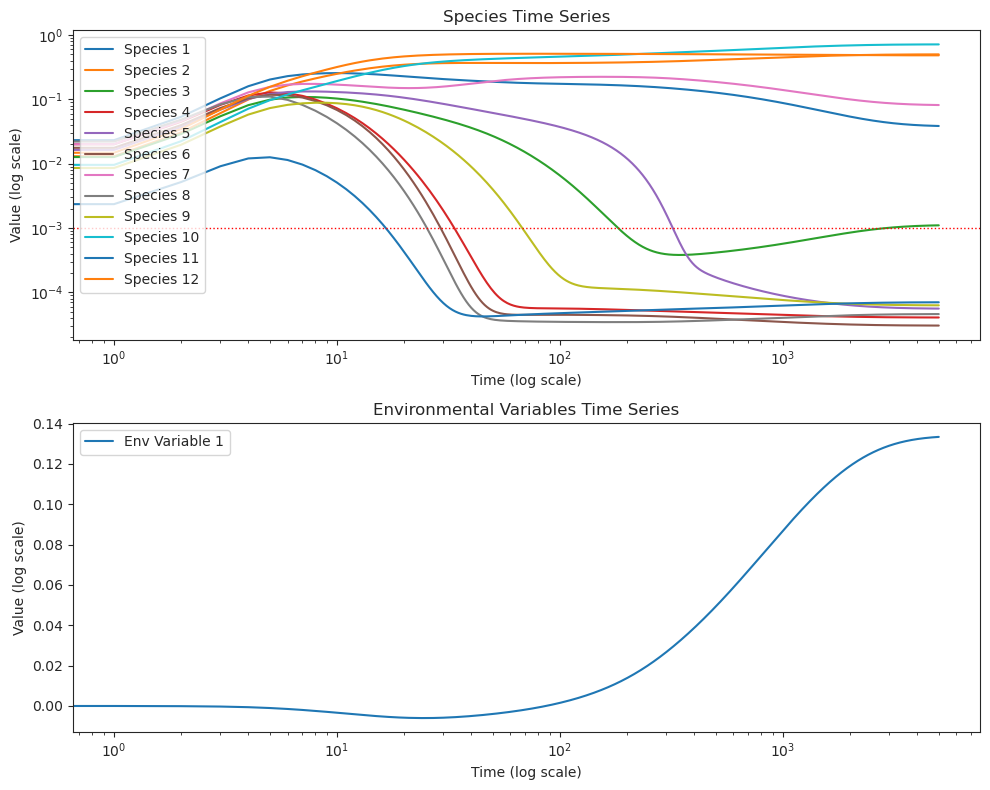

{'species': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 6.32109585e-05, 0.00000000e+00,
       4.81735798e-01, 0.00000000e+00, 7.04399119e-05, 3.06426824e-05,
       1.10406519e-03, 0.00000000e+00, 0.00000000e+00, 4.09105153e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.85145437e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.62313692e-05, 0.00000000e+00, 7.12285720e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.14418825e-02,
       0.00000000e+00, 4.98563431e-01, 0.00000000e+00, 4.62268999e-05]), 'env': array([0.1333615])}


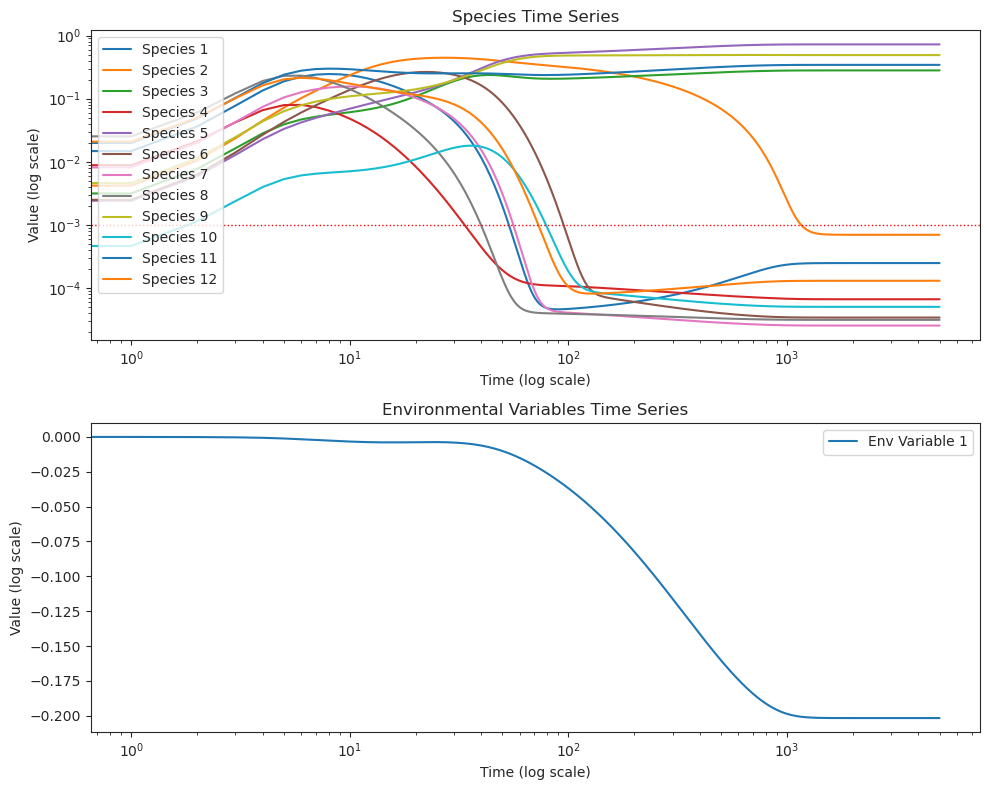

{'species': array([0.00000000e+00, 0.00000000e+00, 6.61106642e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 4.91275016e-01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.38887500e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.11534073e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.43690303e-01, 7.25793828e-01, 0.00000000e+00,
       2.47673107e-04, 0.00000000e+00, 5.00857386e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.52988133e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.29751599e-04, 6.95104832e-04,
       2.80900384e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), 'env': array([-0.20168882])}


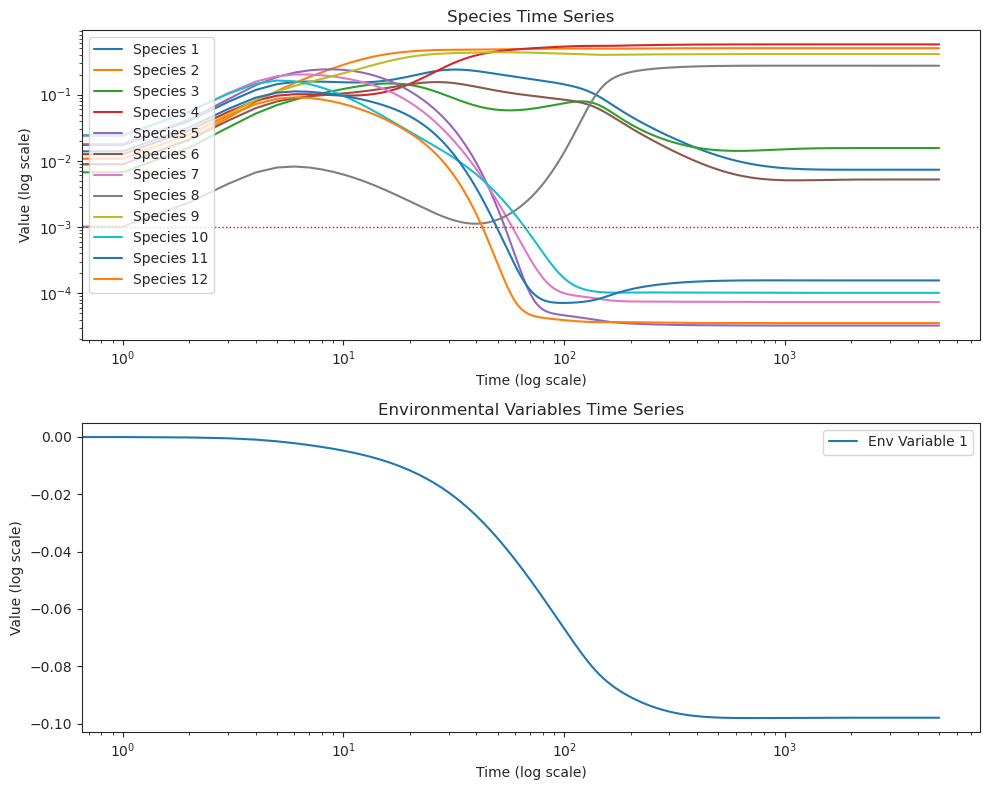

{'species': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.55943156e-02, 7.33676567e-03, 3.53599603e-05,
       7.34920072e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.21677695e-03, 0.00000000e+00, 4.09480758e-01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 5.02301604e-01, 1.01163702e-04,
       2.73246486e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.55676414e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.24006552e-05, 5.73601344e-01, 0.00000000e+00]), 'env': array([-0.09797338])}


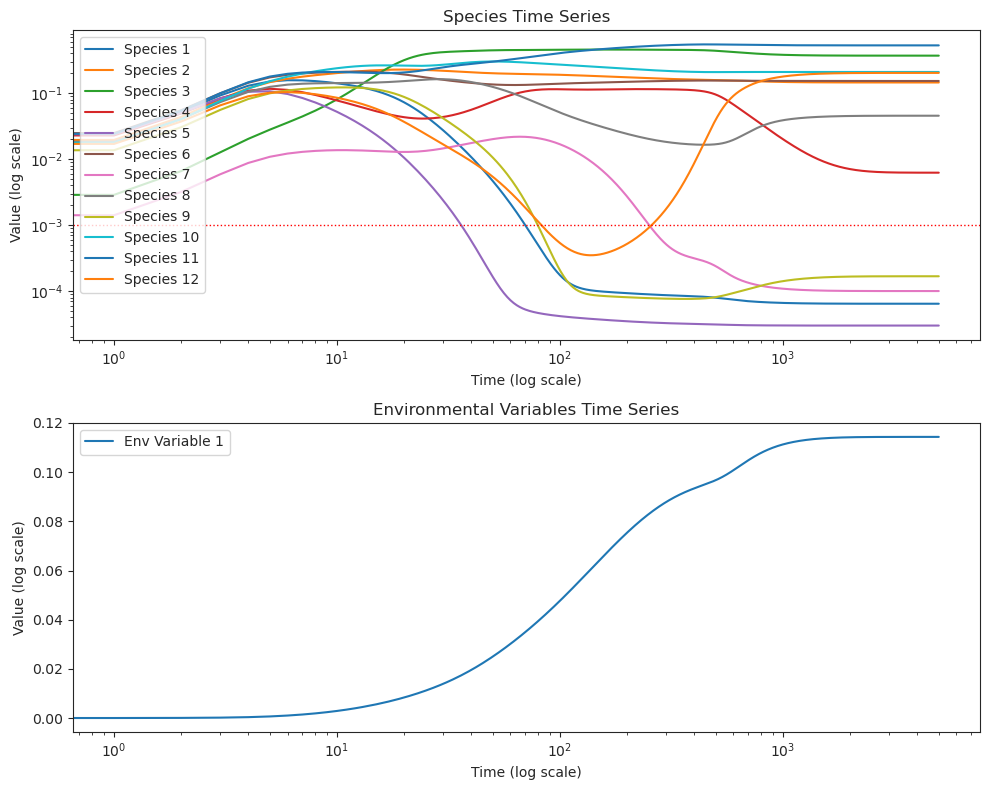

{'species': array([1.52937812e-01, 1.45142340e-01, 2.02809983e-01, 0.00000000e+00,
       2.09323691e-01, 3.70066866e-01, 0.00000000e+00, 6.24150619e-03,
       0.00000000e+00, 5.29470485e-01, 1.68329882e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 4.55307009e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.00462057e-04, 3.01530821e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 6.45699196e-05, 0.00000000e+00, 0.00000000e+00]), 'env': array([0.11434819])}


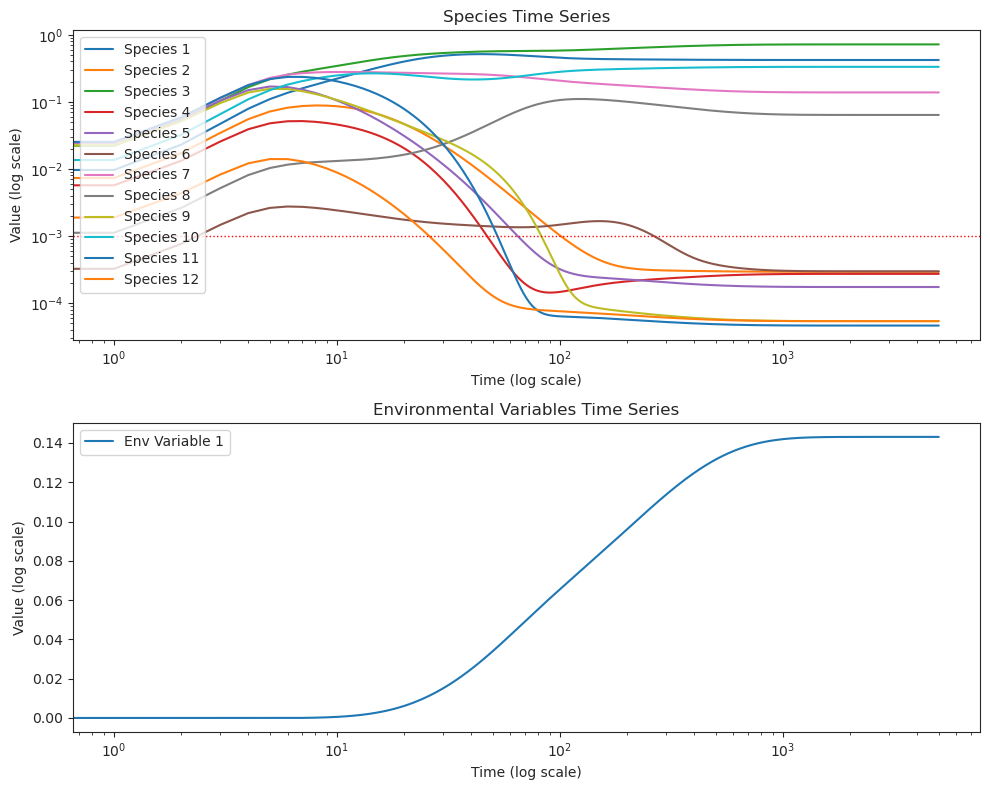

{'species': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.73311014e-04, 0.00000000e+00,
       0.00000000e+00, 7.19455126e-01, 2.93437507e-04, 0.00000000e+00,
       0.00000000e+00, 6.38694327e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 4.63513318e-05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.98403761e-04, 5.39309095e-05,
       0.00000000e+00, 1.38366611e-01, 3.33001302e-01, 0.00000000e+00,
       4.21130980e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.39803548e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.74075522e-04, 0.00000000e+00, 0.00000000e+00]), 'env': array([0.14307495])}


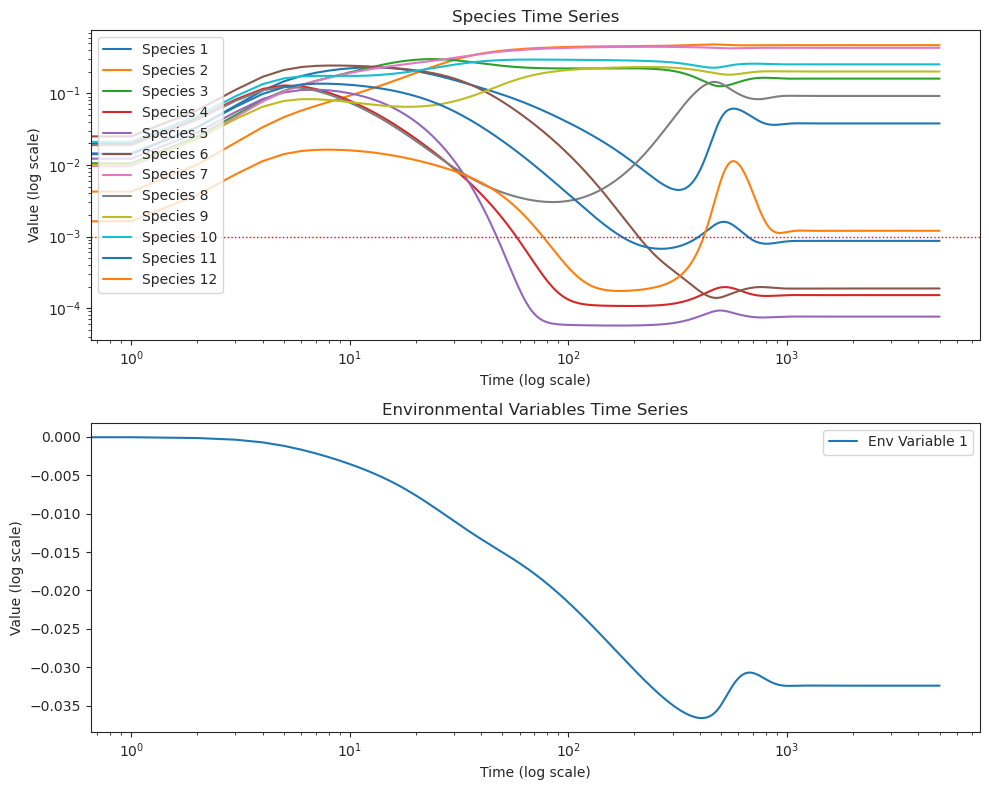

{'species': array([0.00000000e+00, 2.54299590e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.51999415e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.19636931e-02,
       0.00000000e+00, 8.69389964e-04, 0.00000000e+00, 0.00000000e+00,
       4.32526497e-01, 7.61474026e-05, 0.00000000e+00, 3.80006782e-02,
       4.71394706e-01, 0.00000000e+00, 1.20478002e-03, 0.00000000e+00,
       0.00000000e+00, 1.60649903e-01, 2.01797430e-01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.88213068e-04, 0.00000000e+00]), 'env': array([-0.032391])}


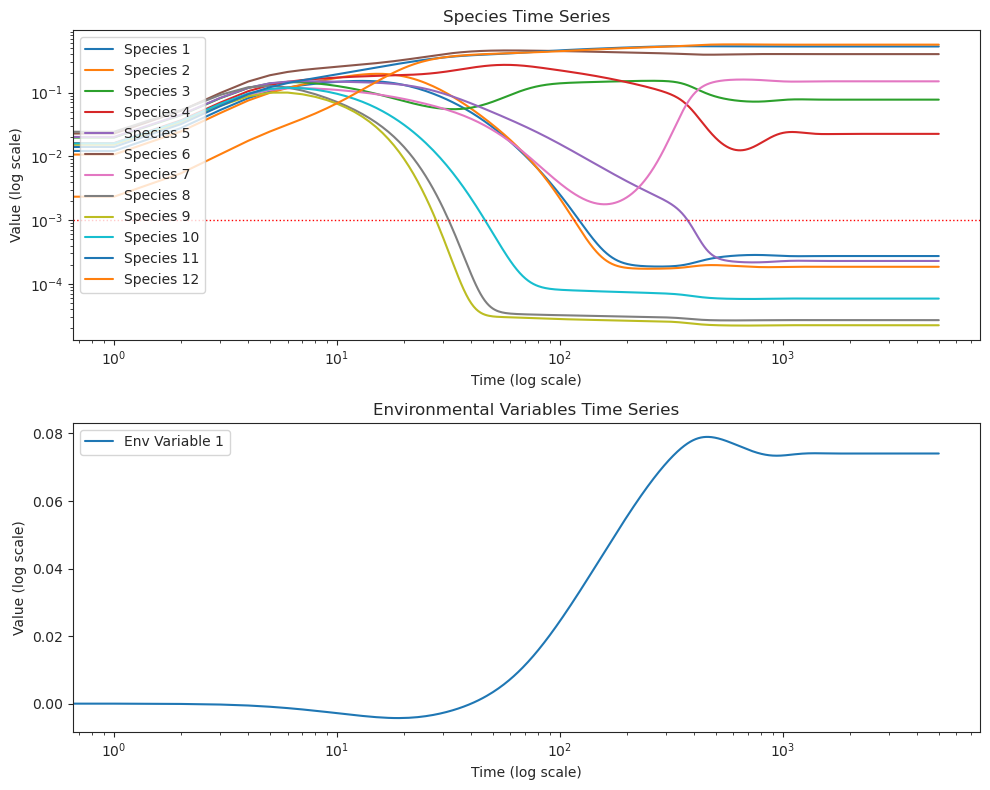

{'species': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.29164597e-04, 2.70432548e-05,
       0.00000000e+00, 0.00000000e+00, 1.85628779e-04, 0.00000000e+00,
       0.00000000e+00, 2.73599966e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.24727898e-05, 0.00000000e+00, 5.65377885e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.25523116e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.50293764e-01,
       5.29360920e-01, 0.00000000e+00, 4.01597467e-01, 7.76125120e-02,
       0.00000000e+00, 0.00000000e+00, 5.88770544e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), 'env': array([0.07407377])}


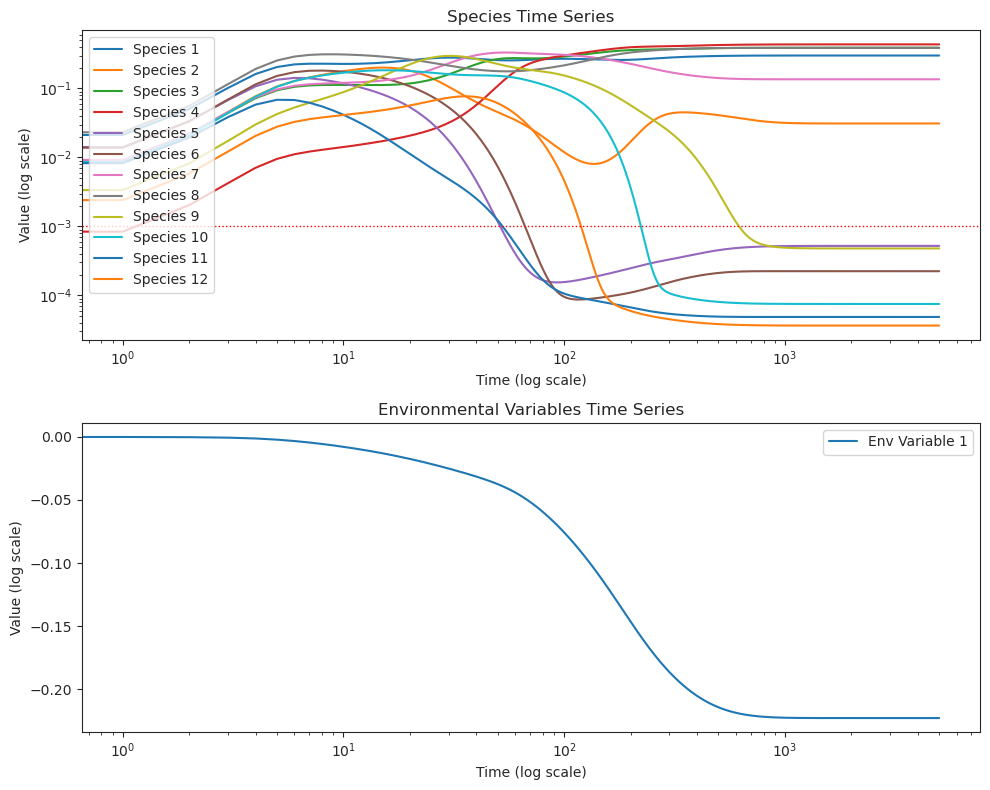

{'species': array([3.10939457e-02, 0.00000000e+00, 7.51637909e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 5.22433704e-04, 0.00000000e+00,
       4.87154858e-05, 0.00000000e+00, 0.00000000e+00, 3.90092285e-01,
       0.00000000e+00, 3.65333164e-05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.87722421e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.00586358e-01, 2.24297762e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.35933721e-01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 4.79530181e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 4.35850149e-01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), 'env': array([-0.2228])}


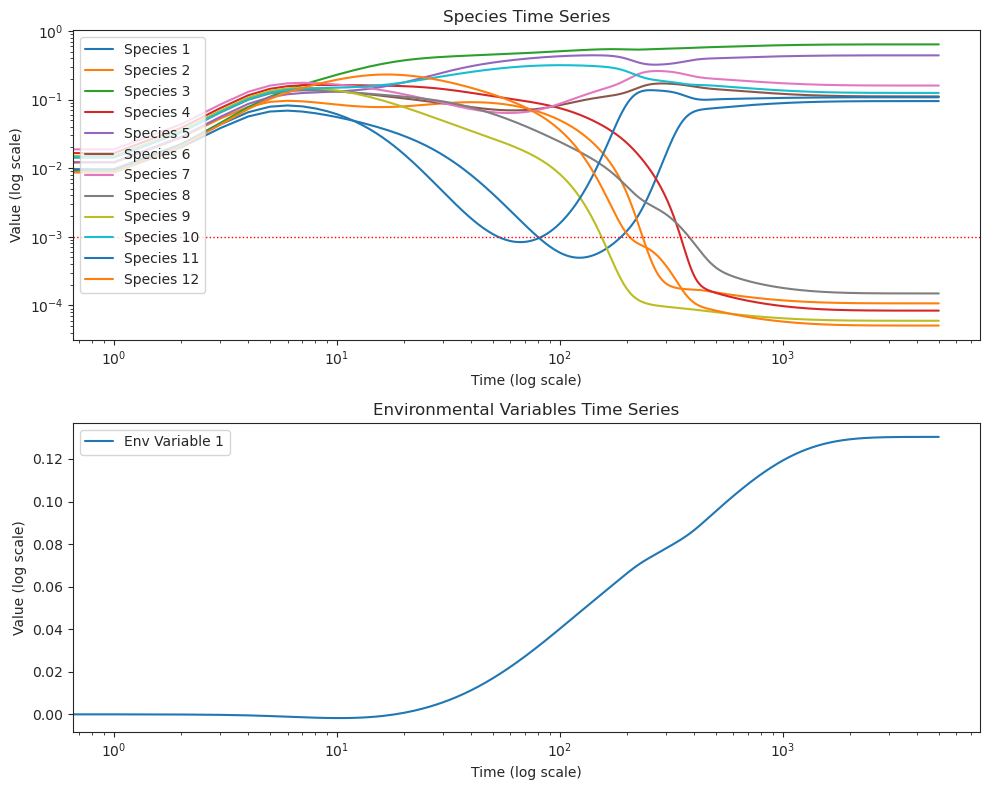

{'species': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.48588607e-02,
       5.08259707e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.07844475e-01, 0.00000000e+00, 8.39077618e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.24785963e-01, 0.00000000e+00, 1.59806503e-01,
       5.97309695e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.07033848e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.35787584e-01,
       1.49340191e-04, 0.00000000e+00, 0.00000000e+00, 1.10927951e-01,
       0.00000000e+00, 4.40072748e-01, 0.00000000e+00, 0.00000000e+00]), 'env': array([0.13038333])}


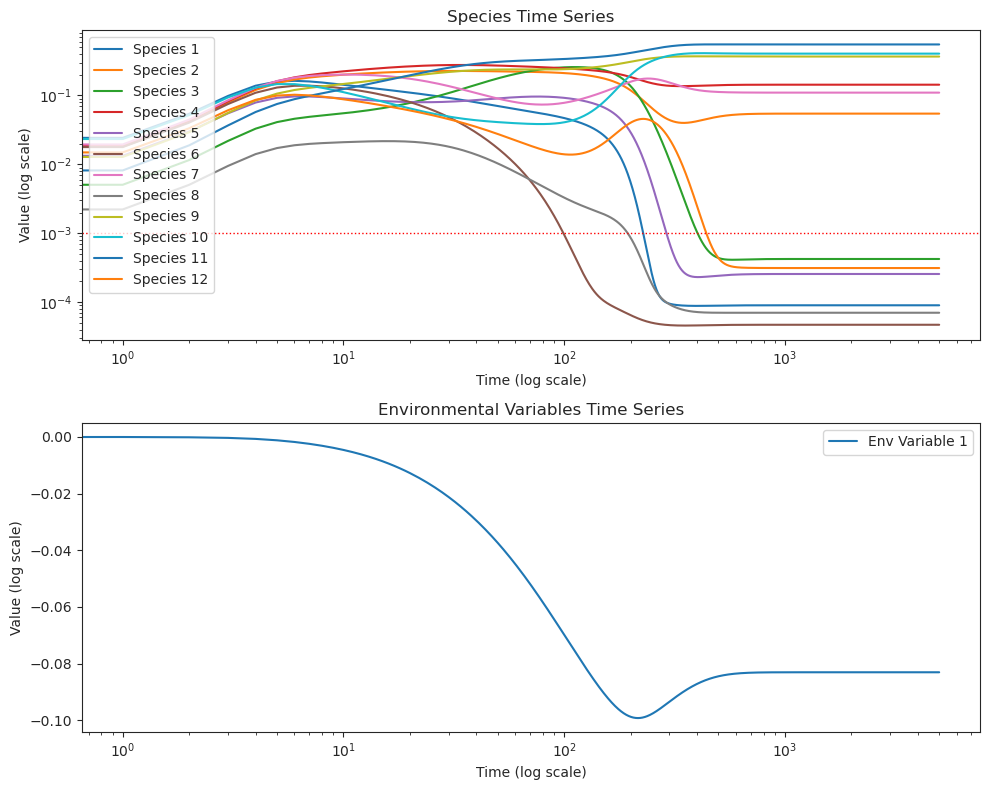

{'species': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 7.02169581e-05, 0.00000000e+00,
       0.00000000e+00, 4.69873911e-05, 0.00000000e+00, 5.44888221e-02,
       2.56381976e-04, 0.00000000e+00, 0.00000000e+00, 3.12735638e-04,
       0.00000000e+00, 1.43233666e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.23307584e-04,
       5.49876099e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.09880604e-01, 3.67055998e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 4.04527407e-01, 9.00780851e-05]), 'env': array([-0.08309312])}


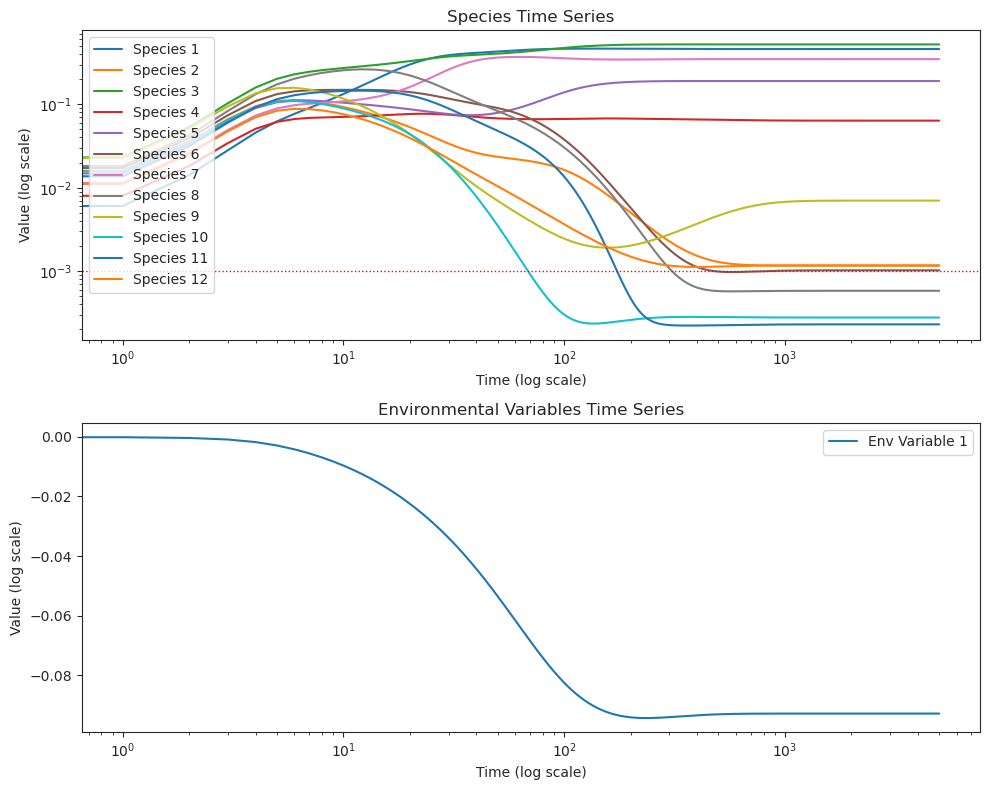

{'species': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.48048793e-01,
       0.00000000e+00, 0.00000000e+00, 5.22165401e-01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.90177807e-01,
       0.00000000e+00, 0.00000000e+00, 4.59759885e-01, 0.00000000e+00,
       0.00000000e+00, 1.02241262e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 7.00126757e-03, 0.00000000e+00, 0.00000000e+00,
       2.29953191e-04, 0.00000000e+00, 1.17198500e-03, 6.36853912e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.77689520e-04, 0.00000000e+00,
       0.00000000e+00, 5.80965510e-04, 0.00000000e+00, 1.16351325e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), 'env': array([-0.09289353])}


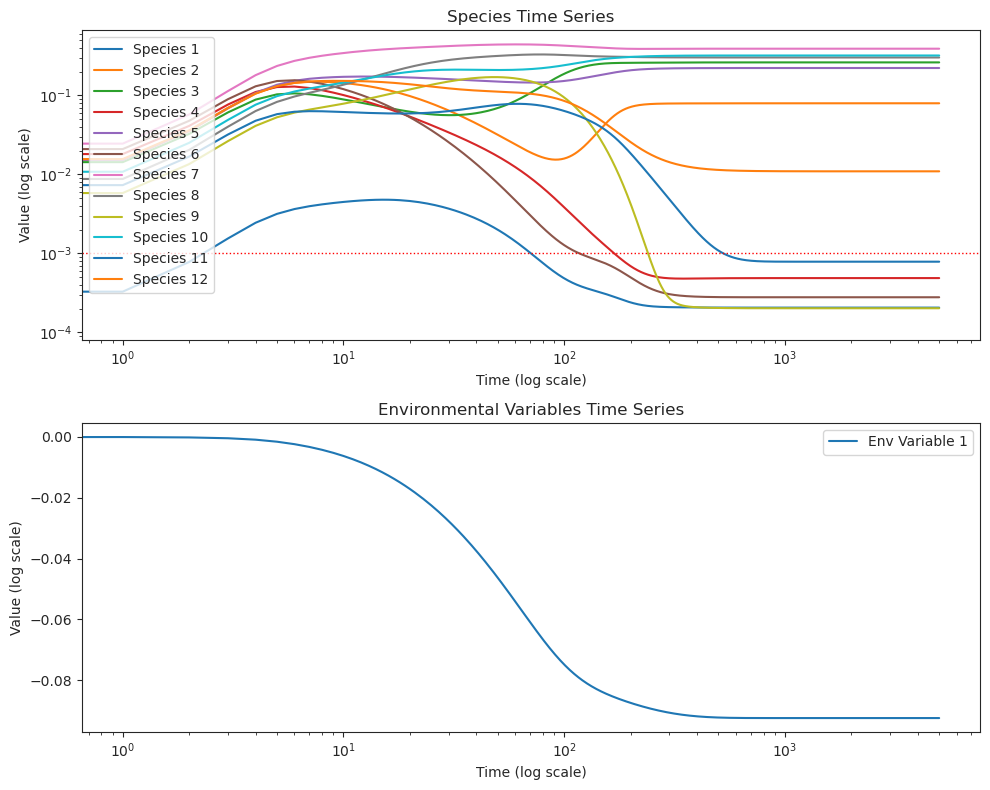

{'species': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.78467526e-04, 0.00000000e+00, 2.02097415e-04, 3.20102965e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.61840583e-01,
       0.00000000e+00, 3.90293787e-01, 0.00000000e+00, 0.00000000e+00,
       1.09396101e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 7.95128315e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 7.85322131e-04, 0.00000000e+00,
       4.87045118e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.22301670e-01, 0.00000000e+00,
       3.02083061e-01, 2.05854970e-04, 0.00000000e+00, 0.00000000e+00]), 'env': array([-0.09247296])}


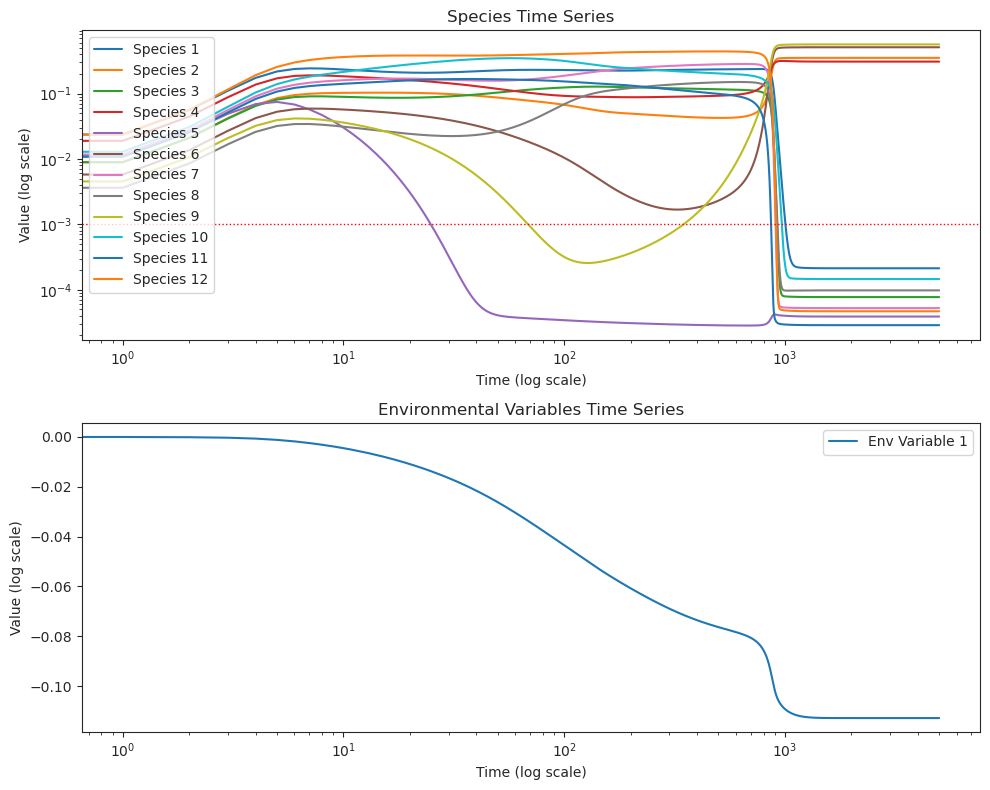

{'species': array([0.00000000e+00, 5.24042549e-05, 3.89114545e-05, 0.00000000e+00,
       0.00000000e+00, 7.72009278e-05, 3.50939848e-01, 0.00000000e+00,
       0.00000000e+00, 2.87212266e-05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.07555718e-01, 0.00000000e+00, 0.00000000e+00, 4.68637487e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.45575604e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.63688980e-01, 0.00000000e+00, 0.00000000e+00, 2.12907958e-04,
       5.09687358e-01, 0.00000000e+00, 9.78015832e-05, 0.00000000e+00]), 'env': array([-0.11280543])}


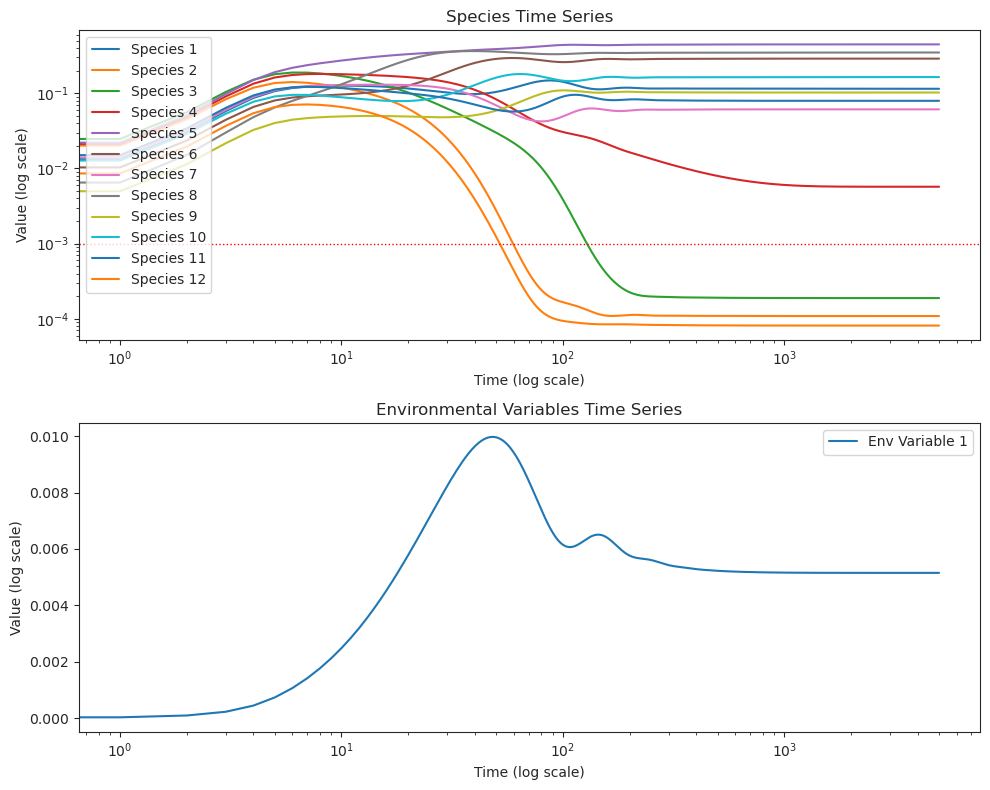

{'species': array([0.00000000e+00, 0.00000000e+00, 7.92784057e-02, 1.64135328e-01,
       6.10371792e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.14666516e-01, 1.08862967e-04, 2.88539650e-01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.46215647e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.47987171e-01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.70927112e-03,
       8.13434568e-05, 1.02177527e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.88713807e-04, 0.00000000e+00]), 'env': array([0.00515012])}


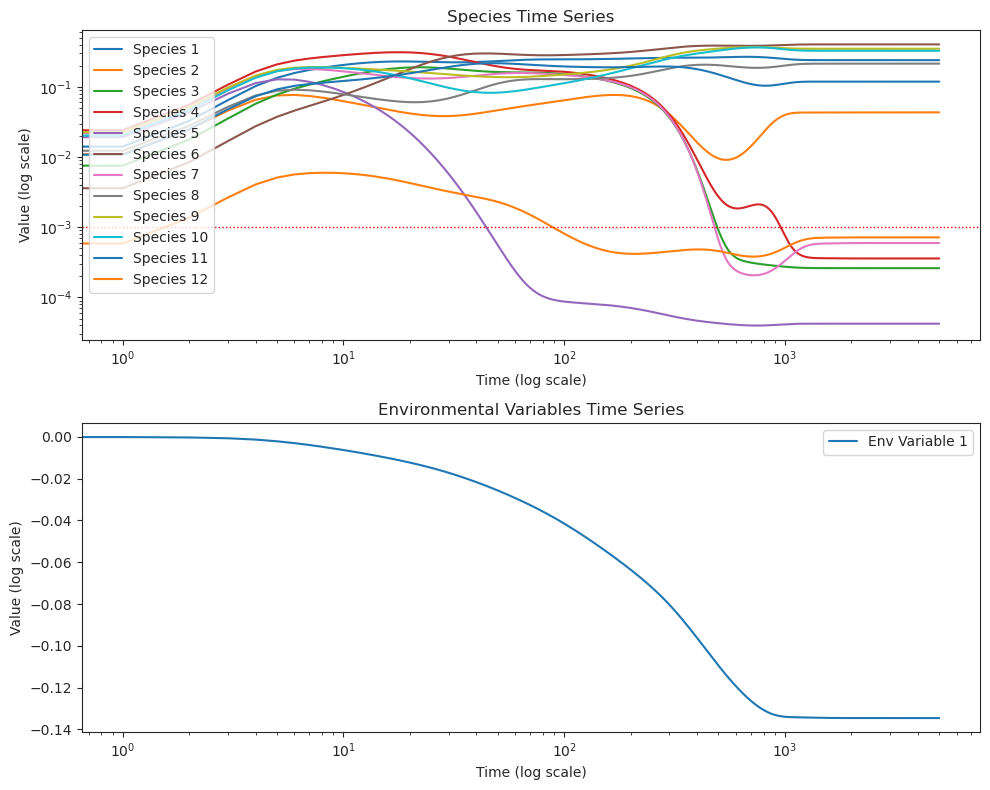

{'species': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.40437345e-01, 0.00000000e+00, 0.00000000e+00,
       2.14509445e-01, 0.00000000e+00, 0.00000000e+00, 4.33636066e-02,
       2.61407790e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.59438826e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 4.23301545e-05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.49692788e-01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.18785197e-01,
       0.00000000e+00, 0.00000000e+00, 5.96361628e-04, 4.03276323e-01,
       7.17990653e-04, 0.00000000e+00, 3.26865678e-01, 0.00000000e+00]), 'env': array([-0.13454797])}


In [29]:
np.random.seed(42)
system_config['beta'] = np.array([0.002])

for i in range(20):
    species_index=np.random.choice(48, size=12, replace=False)
    env_index=np.array([0])
    y0_species=np.random.rand(12)*0.01
    y0_env=[0]
    t=np.linspace(0, 5000, 5000)

    y_out = run_gLV_env_dynamics(y0_species, y0_env, t, system_config, species_index, env_index, to_plot=True)

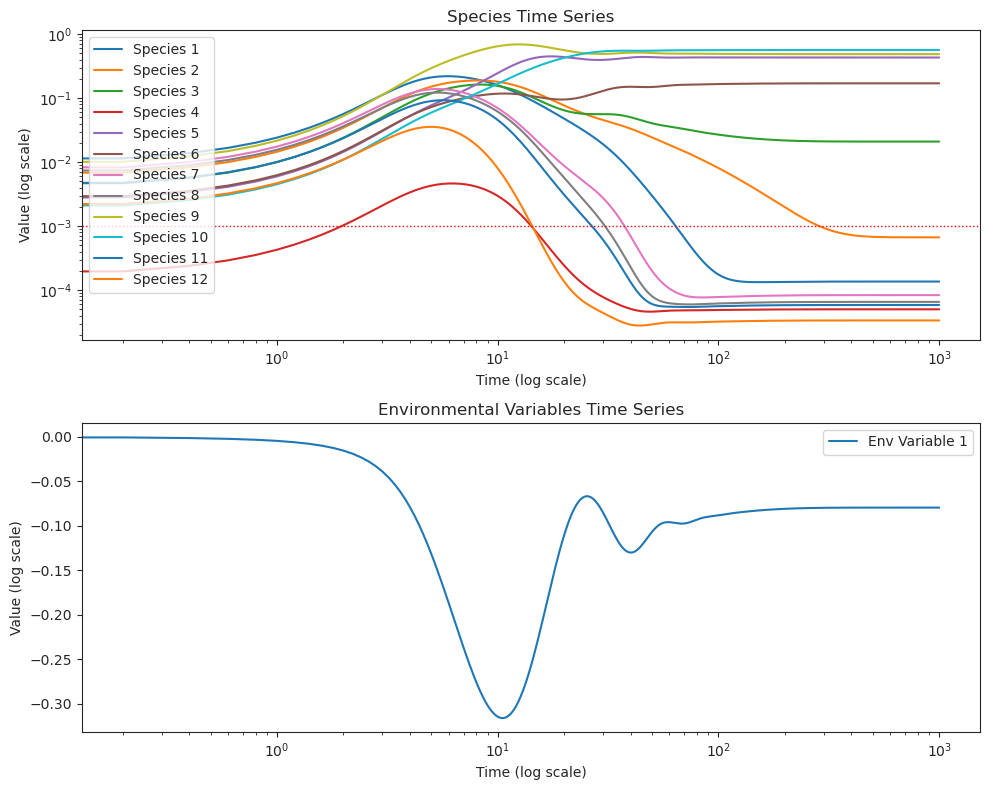

{'species': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.35084388e-05,
       4.86529616e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.84884394e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       8.33948902e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.53631308e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.30848059e-01, 5.64973986e-01, 2.09297476e-02, 1.35908668e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.70235440e-01, 0.00000000e+00, 0.00000000e+00,
       6.67211023e-04, 0.00000000e+00, 0.00000000e+00, 5.00365257e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), 'env': array([-0.0795558])}


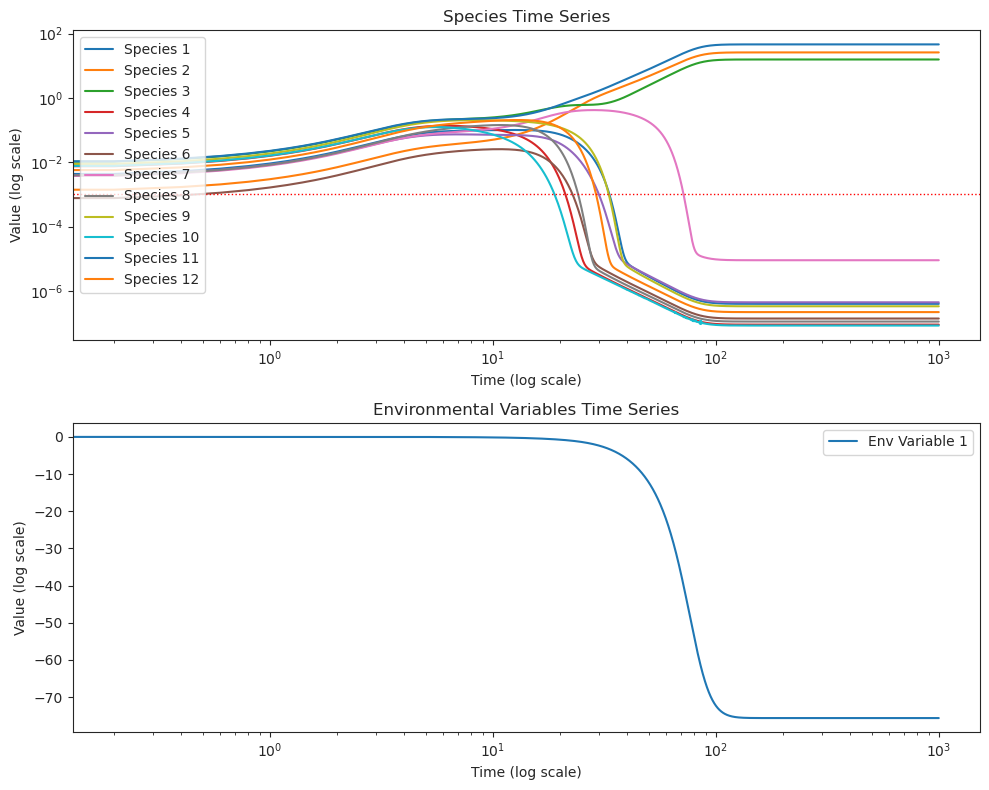

{'species': array([0.00000000e+00, 0.00000000e+00, 8.46255322e-08, 0.00000000e+00,
       1.56237837e+01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.12718351e-07, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.40036643e-07, 0.00000000e+00, 4.60056117e+01, 2.21696481e-07,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 4.46653549e-07, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.36211100e-07, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 9.05920013e-06, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.00346766e-07,
       0.00000000e+00, 9.05843539e-08, 2.59217124e+01, 0.00000000e+00]), 'env': array([-75.65758879])}


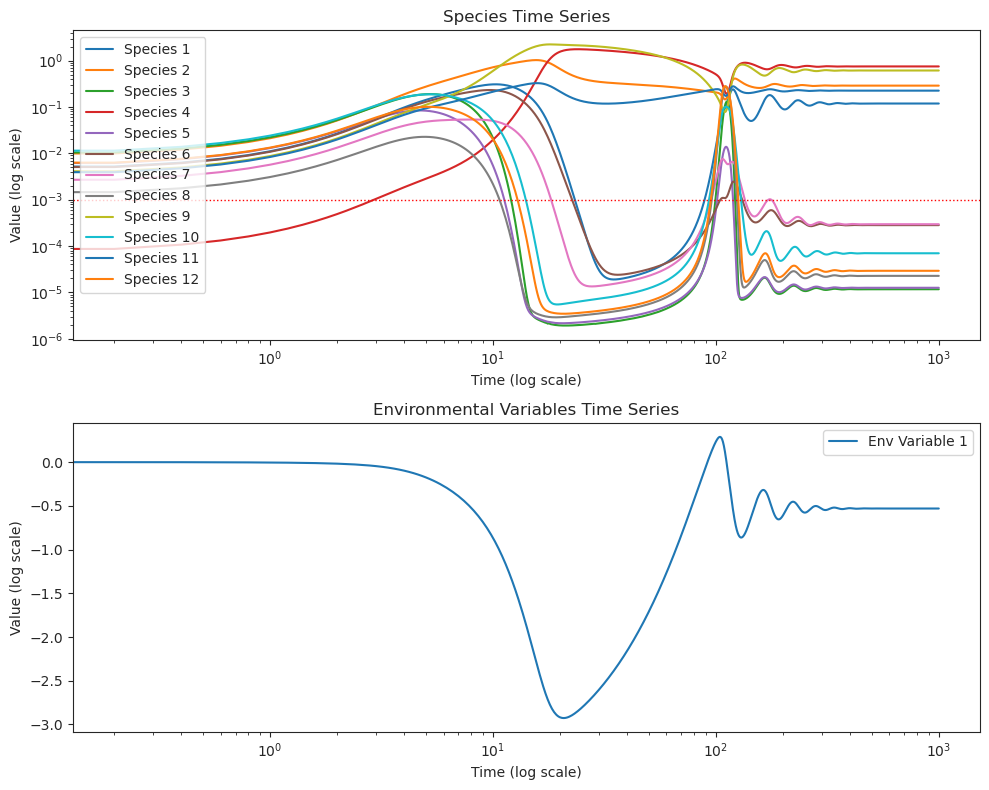

{'species': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.92253504e-05, 0.00000000e+00, 1.16960306e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.82473482e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.49515434e-01,
       0.00000000e+00, 1.18776096e-01, 6.12513723e-01, 0.00000000e+00,
       2.25101461e-01, 2.27109942e-05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 6.97971489e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.25759413e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.95886704e-04,
       2.88753358e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), 'env': array([-0.53103611])}


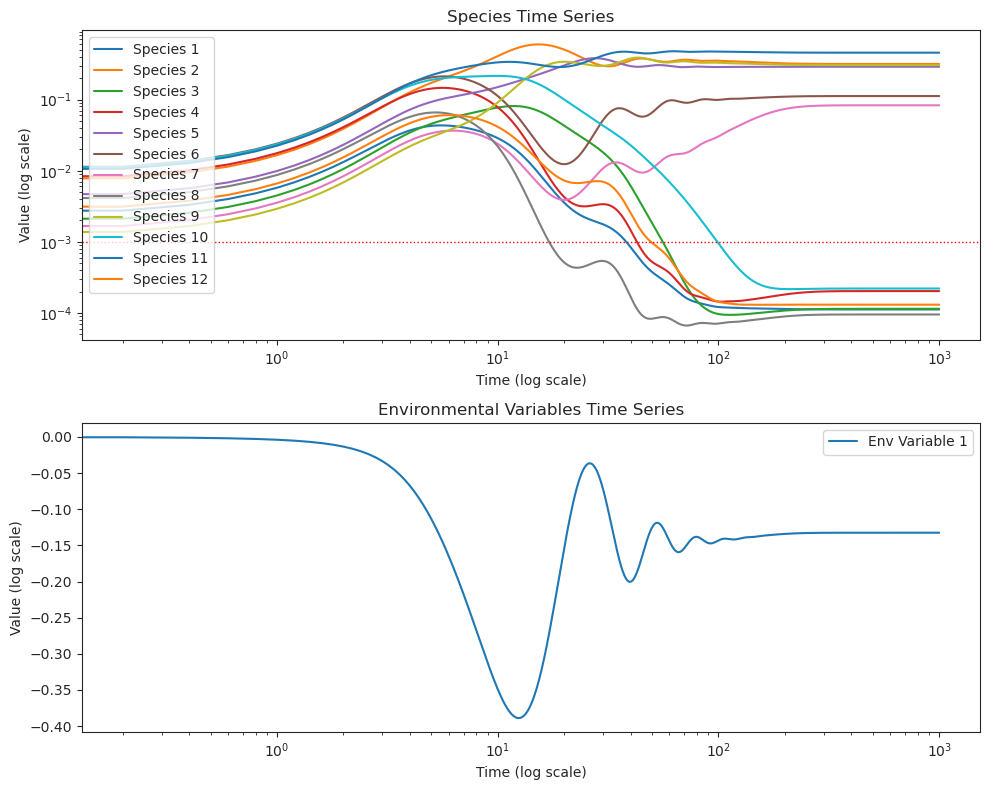

{'species': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.89234188e-01, 1.12114098e-01,
       0.00000000e+00, 8.31192174e-02, 0.00000000e+00, 0.00000000e+00,
       1.12130588e-04, 9.52847355e-05, 0.00000000e+00, 3.16951882e-01,
       0.00000000e+00, 4.56489092e-01, 0.00000000e+00, 1.14434427e-04,
       0.00000000e+00, 1.30899666e-04, 0.00000000e+00, 0.00000000e+00,
       3.05164441e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.03086407e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.20836315e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), 'env': array([-0.13249614])}


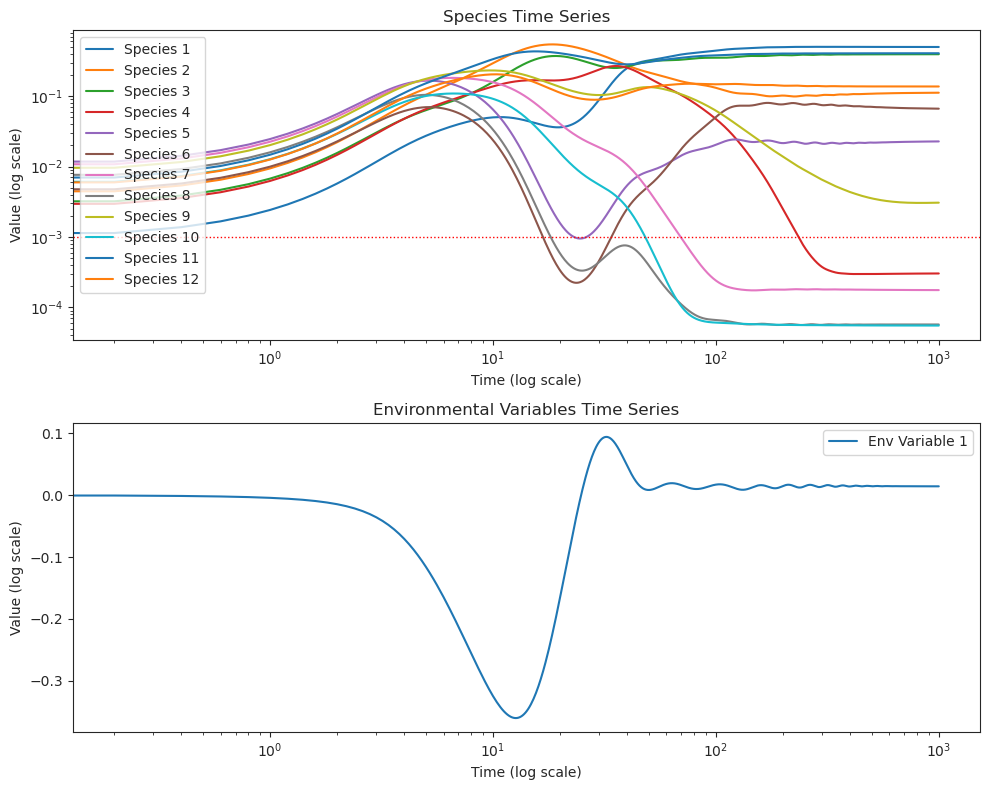

{'species': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 4.99659000e-01, 0.00000000e+00,
       0.00000000e+00, 6.64409267e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.27735725e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.71898380e-05, 0.00000000e+00, 0.00000000e+00,
       3.94376604e-01, 0.00000000e+00, 1.37295781e-01, 0.00000000e+00,
       1.11988575e-01, 3.07196805e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.03322824e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.76107097e-04, 5.52051813e-05,
       4.07090421e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), 'env': array([0.01431101])}


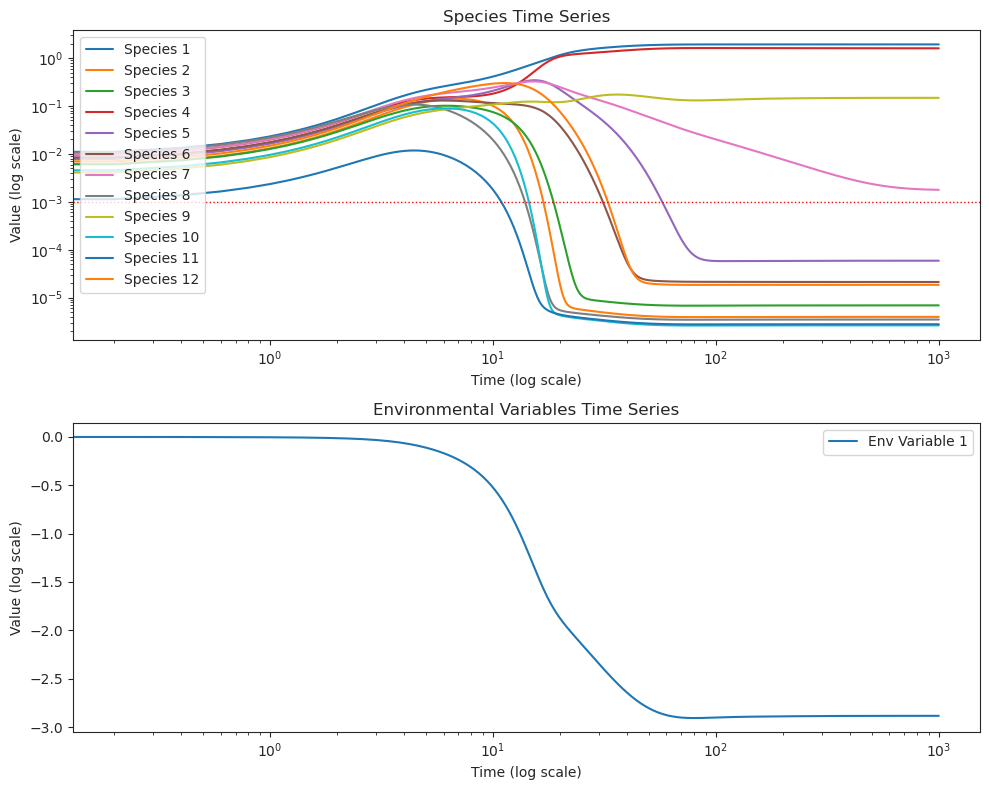

{'species': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.48198434e-01, 0.00000000e+00,
       1.85099397e-05, 0.00000000e+00, 2.78816622e-06, 2.12433345e-05,
       6.90700250e-06, 0.00000000e+00, 0.00000000e+00, 1.60033057e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.93102706e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.90559997e-05, 0.00000000e+00, 2.64086469e-06,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.78014373e-03,
       0.00000000e+00, 3.97287125e-06, 0.00000000e+00, 3.49597290e-06]), 'env': array([-2.88404303])}


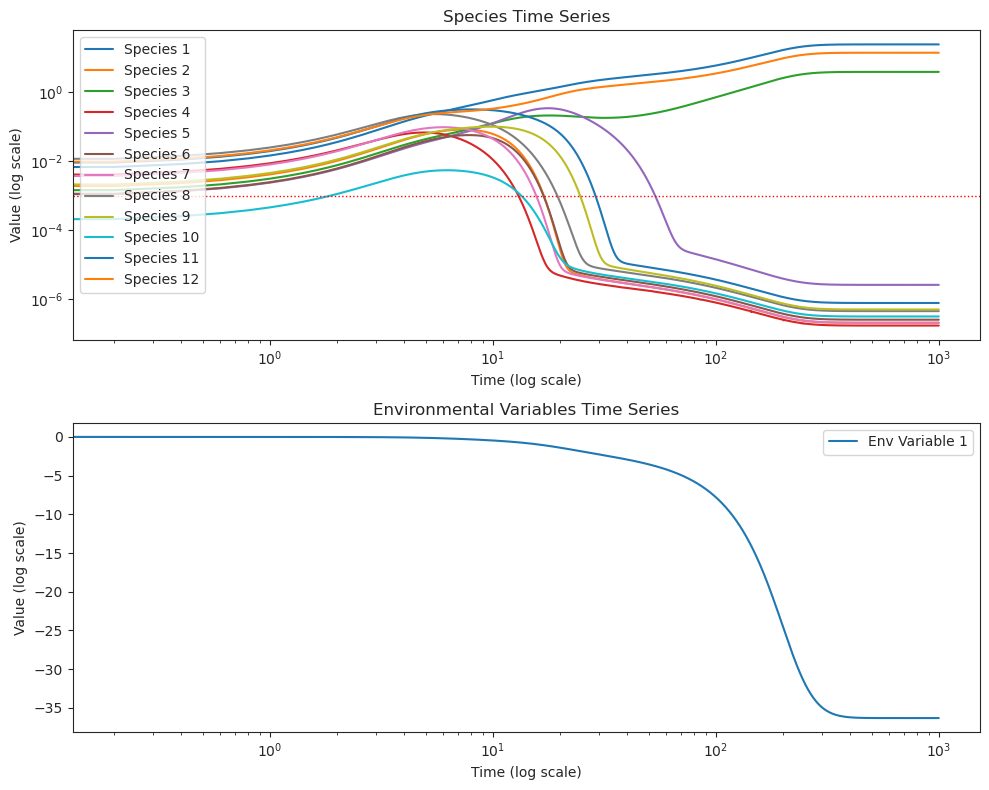

{'species': array([0.00000000e+00, 0.00000000e+00, 1.71616846e-07, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 5.02841416e-07, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.54111266e-07, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.50402152e-07,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 7.76558138e-07, 2.60585971e-06, 0.00000000e+00,
       2.48937701e+01, 0.00000000e+00, 3.14873205e-07, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.09159158e-07, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.42600174e+01, 2.05217865e-07,
       3.96110725e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), 'env': array([-36.30766661])}


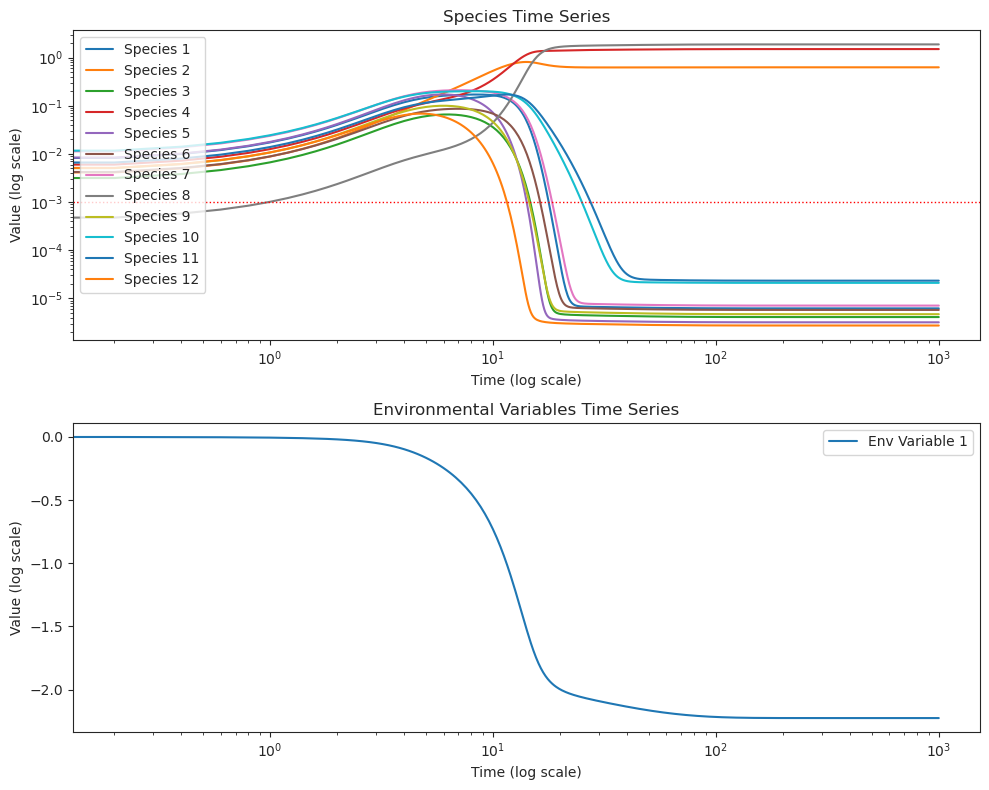

{'species': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 4.09860549e-06, 6.20817759e-06, 2.73576823e-06,
       7.09306952e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.76710263e-06, 0.00000000e+00, 4.70001765e-06, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 6.29034113e-01, 2.10358128e-05,
       1.88205051e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.33601884e-05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.18953817e-06, 1.50371523e+00, 0.00000000e+00]), 'env': array([-2.22545271])}


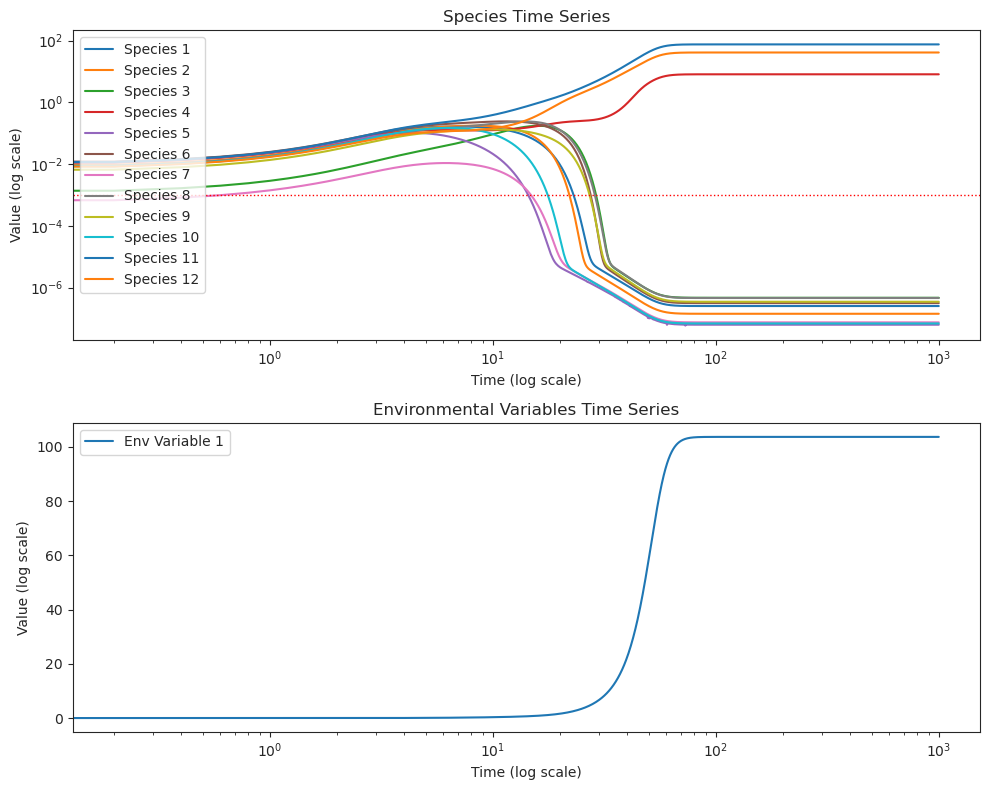

{'species': array([3.14294992e-07, 1.42146886e-07, 4.12666936e+01, 0.00000000e+00,
       6.90913489e-08, 4.68839638e-07, 0.00000000e+00, 8.11226357e+00,
       0.00000000e+00, 7.54897702e+01, 3.49032698e-07, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 4.60541419e-07, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 7.50155381e-08, 6.28847448e-08,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.53080286e-07, 0.00000000e+00, 0.00000000e+00]), 'env': array([103.68048334])}


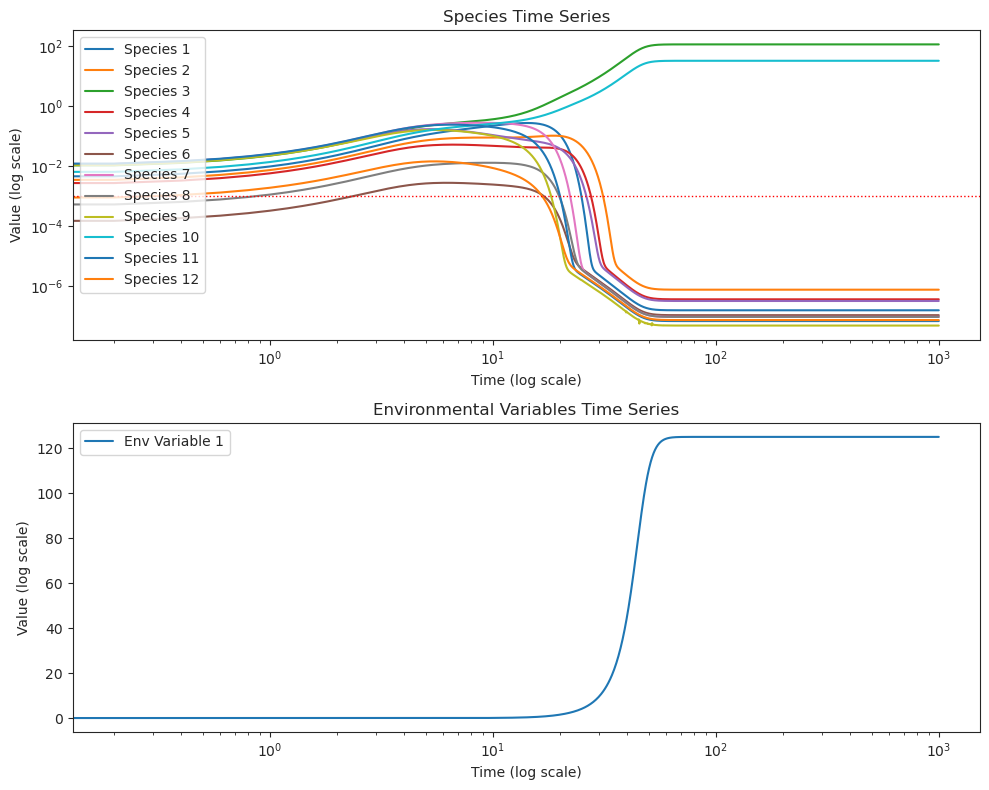

{'species': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.62767188e-07, 0.00000000e+00,
       0.00000000e+00, 1.12954047e+02, 7.59264698e-07, 0.00000000e+00,
       0.00000000e+00, 9.39217493e-08, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 6.82830340e-08, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.07472002e-07, 7.38108030e-08,
       0.00000000e+00, 9.45311242e-08, 3.21308491e+01, 0.00000000e+00,
       1.56278145e-07, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.84125813e-08, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.19073330e-07, 0.00000000e+00, 0.00000000e+00]), 'env': array([125.01679673])}


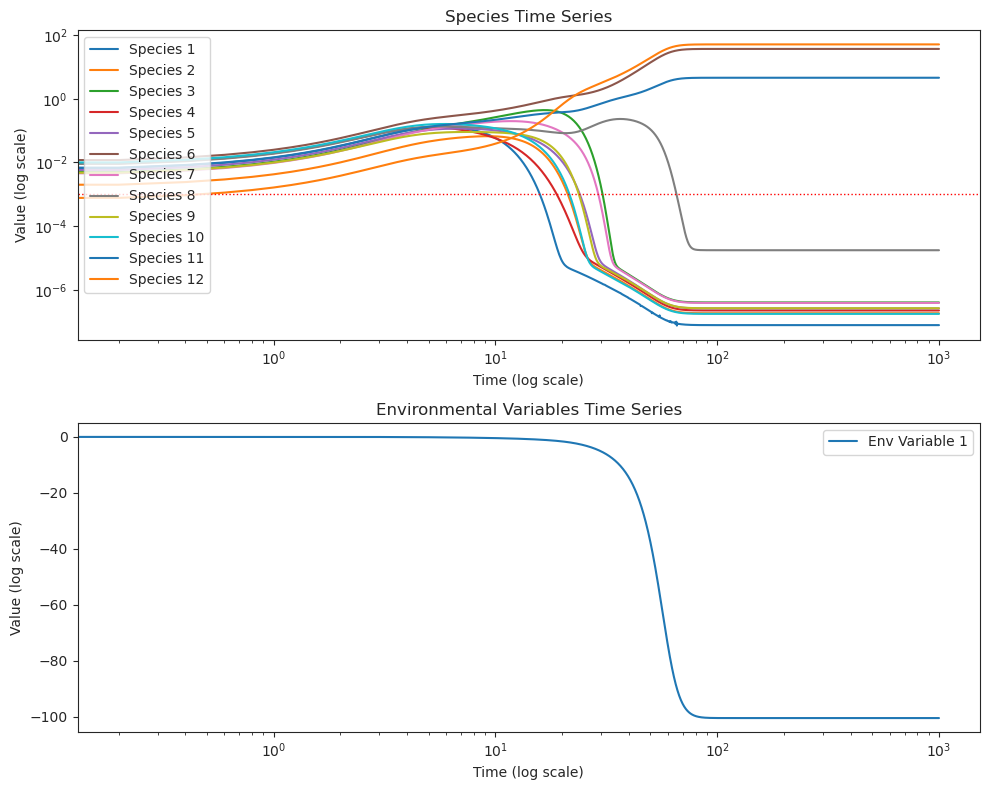

{'species': array([0.00000000e+00, 1.74253021e-07, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.22699040e-07, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.74424451e-05,
       0.00000000e+00, 4.61577128e+00, 0.00000000e+00, 0.00000000e+00,
       3.84344271e-07, 2.58954264e-07, 0.00000000e+00, 7.70978525e-08,
       1.82126356e-07, 0.00000000e+00, 5.16244225e+01, 0.00000000e+00,
       0.00000000e+00, 3.98001640e-07, 2.61662312e-07, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.71892321e+01, 0.00000000e+00]), 'env': array([-100.51307583])}


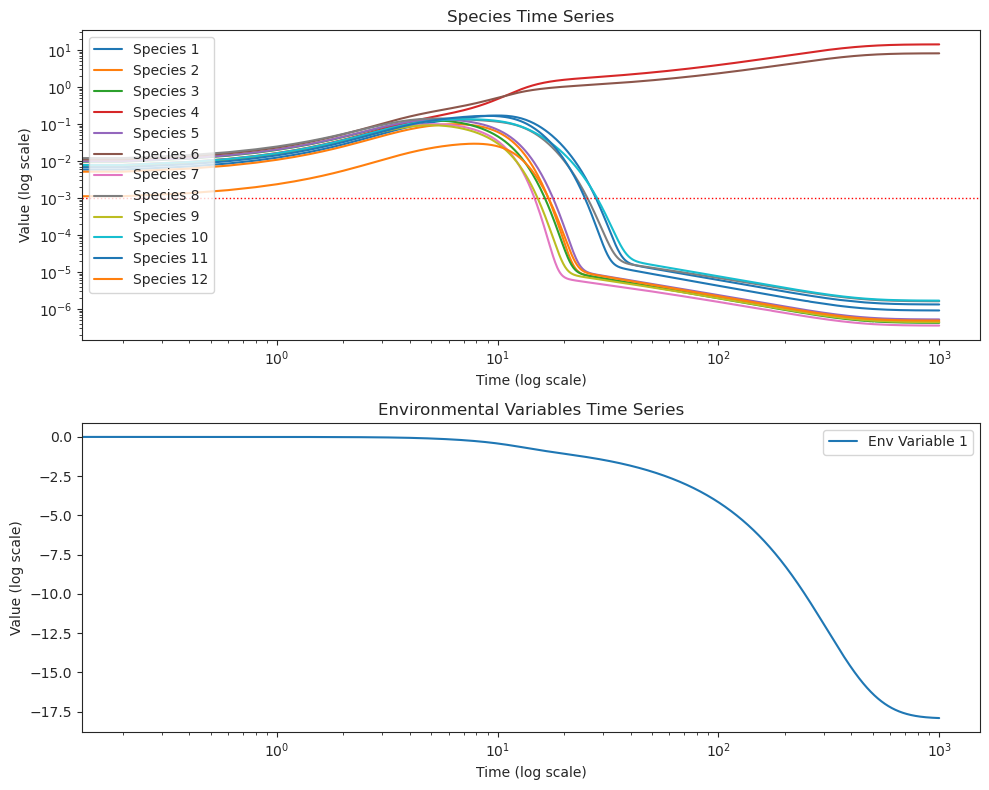

{'species': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 5.17458398e-07, 1.60345076e-06,
       0.00000000e+00, 0.00000000e+00, 4.48994544e-07, 0.00000000e+00,
       0.00000000e+00, 1.31470031e-06, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 4.37912907e-07, 0.00000000e+00, 4.80874604e-07,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.40077709e+01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.53288389e-07,
       9.04262652e-07, 0.00000000e+00, 8.03209146e+00, 4.18976084e-07,
       0.00000000e+00, 0.00000000e+00, 1.66765538e-06, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), 'env': array([-17.9122695])}


In [24]:
np.random.seed(42)
system_config['beta'] = np.array([0.2])

for i in range(12):
    species_index=np.random.choice(48, size=12, replace=False)
    env_index=np.array([0])
    y0_species=np.random.rand(12)*0.01
    y0_env=[0]
    t=np.linspace(0, 1000, 5000)

    y_out = run_gLV_env_dynamics(y0_species, y0_env, t, system_config, species_index, env_index, to_plot=True)

In [ ]:
system_config

In [ ]:
system_config

In [ ]:
np.random.seed(42)
system_config['beta'] = np.array([40])

species_index=np.arange(0,12)
env_index=np.array([0])

for i in range(12):
    y0_species=one_hot_vector(12,i)
    y0_env=[0]
    t=np.linspace(0, 1000, 5000)

    y_out = run_gLV_env_dynamics(y0_species, y0_env, t, system_config, species_index, env_index, to_plot=True)